# Przewidywanie dokonania zakupu przez klienta - po segmentacji

### Przygotowanie środowiska

Instalacja LightGBM z obsługą GPU

In [ ]:
! git clone --recursive https://github.com/Microsoft/LightGBM
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

Cloning into 'LightGBM'...
remote: Enumerating objects: 26256, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 26256 (delta 21), reused 4 (delta 2), pack-reused 26199
Receiving objects: 100% (26256/26256), 19.02 MiB | 35.21 MiB/s, done.
Resolving deltas: 100% (19403/19403), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Compressing

In [1]:
# data prepartaion and visualization
import numpy as np 
import pandas as pd
import math
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from sklearn import tree
from xgboost import plot_importance
from xgboost import plot_tree
from lightgbm import plot_importance as plot_importance_lgbm
from lightgbm import plot_tree as plot_tree_lgbm

# model evalution
import time
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# settings
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('ticks')

# time
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 1.83 ms (started: 2022-06-16 20:47:34 +00:00)


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 14 08:59:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
time: 2.79 ms (started: 2022-06-14 08:59:05 +00:00)


### Wczytanie, połączenie i przygotowanie zbioru danych

In [2]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/all_months_no_segments.csv", index_col=0)
df_segments = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/archive/all_customers_with_segments.csv", index_col=0)

time: 30.9 s (started: 2022-06-16 20:47:34 +00:00)


In [3]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11455091 entries, 0 to 11455090
Data columns (total 16 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   user_id                11455091 non-null  int64  
 1   brand                  11455091 non-null  object 
 2   category_code_level1   11455091 non-null  object 
 3   category_code_level2   11455091 non-null  object 
 4   price                  11455091 non-null  float64
 5   event_year             11455091 non-null  int64  
 6   event_month            11455091 non-null  int64  
 7   event_monthday         11455091 non-null  int64  
 8   week_no                11455091 non-null  int64  
 9   event_weekday          11455091 non-null  int64  
 10  event_hour             11455091 non-null  int64  
 11  activity_count         11455091 non-null  int64  
 12  activity_count_month   11455091 non-null  int64  
 13  avg_weekly_sale_price  11455091 non-null  float64
 14  

In [4]:
df_segments.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1817173 entries, 0 to 1817172
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   recency     1817173 non-null  int64  
 1   frequency   1817173 non-null  int64  
 2   monetary    1817173 non-null  float64
 3   clusters_3  1817173 non-null  int64  
 4   user_id     1817173 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 83.2 MB
time: 20 ms (started: 2022-06-16 20:48:07 +00:00)


Połączenie zbiorów danych

In [5]:
df = df.merge(df_segments, on='user_id', how='left')
drop_list = ["recency", "frequency", "monetary"]
df.drop(drop_list, axis=1, inplace=True)
df.head()

,user_id,brand,category_code_level1,category_code_level2,price,event_year,event_month,event_monthday,week_no,event_weekday,event_hour,activity_count,activity_count_month,avg_weekly_sale_price,weekly_sales_count,is_purchased,clusters_3
0,524325294,apple,electronics,smartphone,515.67,2019,10,1,0,1,0,4,7,514.017143,1531,1,1.0
1,533624186,apple,electronics,audio,161.98,2019,10,1,0,1,0,4,22,161.416667,2733,0,1.0
2,536415846,samsung,electronics,smartphone,174.76,2019,10,1,0,1,2,7,12,173.951667,2413,0,1.0
3,513632293,huawei,electronics,smartphone,258.21,2019,10,1,0,1,2,16,29,255.615714,218,1,1.0
4,555110488,samsung,electronics,smartphone,197.43,2019,10,1,0,1,2,10,61,198.097143,1064,1,1.0


time: 6.43 s (started: 2022-06-16 20:48:07 +00:00)


Usunięcie zbędnych kolumn, zakodowanie zmiennych.

In [6]:
drop_list = ["user_id", "event_year"]
df.drop(drop_list, axis=1, inplace=True)

df.loc[:,'brand'] = LabelEncoder().fit_transform(df.loc[:,'brand'].copy())
df.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(df.loc[:,'category_code_level1'].copy())
df.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(df.loc[:,'category_code_level2'].copy())
df = df.dropna(subset=["clusters_3"]).reset_index(drop=True)
df

,brand,category_code_level1,category_code_level2,price,event_month,event_monthday,week_no,event_weekday,event_hour,activity_count,activity_count_month,avg_weekly_sale_price,weekly_sales_count,is_purchased,clusters_3
0,235,7,44,515.67,10,1,0,1,0,4,7,514.017143,1531,1,1.0
1,235,7,1,161.98,10,1,0,1,0,4,22,161.416667,2733,0,1.0
2,3676,7,44,174.76,10,1,0,1,2,7,12,173.951667,2413,0,1.0
3,1887,7,44,258.21,10,1,0,1,2,16,29,255.615714,218,1,1.0
4,3676,7,44,197.43,10,1,0,1,2,10,61,198.097143,1064,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8886187,1598,8,28,143.86,4,30,30,3,23,3,38,134.855000,32,0,0.0
8886188,2032,11,6,10.53,4,30,30,3,23,8,21,10.530000,9,1,0.0
8886189,293,2,19,53.77,4,30,30,3,23,4,15,53.770000,4,0,1.0
8886190,3676,5,51,276.00,4,30,30,3,23,8,20,278.775833,125,0,1.0


time: 11.9 s (started: 2022-06-16 20:48:13 +00:00)


Ustawienie kolumn w odpowiedniej kolejności

In [7]:
new_col_order = ["brand", "category_code_level1", "category_code_level2", "price", "event_month", "event_monthday", "week_no", "event_weekday", "event_hour", "activity_count", "activity_count_month", "avg_weekly_sale_price", "weekly_sales_count", "clusters_3", "is_purchased"]

df = df[new_col_order]
df

,brand,category_code_level1,category_code_level2,price,event_month,event_monthday,week_no,event_weekday,event_hour,activity_count,activity_count_month,avg_weekly_sale_price,weekly_sales_count,clusters_3,is_purchased
0,235,7,44,515.67,10,1,0,1,0,4,7,514.017143,1531,1.0,1
1,235,7,1,161.98,10,1,0,1,0,4,22,161.416667,2733,1.0,0
2,3676,7,44,174.76,10,1,0,1,2,7,12,173.951667,2413,1.0,0
3,1887,7,44,258.21,10,1,0,1,2,16,29,255.615714,218,1.0,1
4,3676,7,44,197.43,10,1,0,1,2,10,61,198.097143,1064,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8886187,1598,8,28,143.86,4,30,30,3,23,3,38,134.855000,32,0.0,0
8886188,2032,11,6,10.53,4,30,30,3,23,8,21,10.530000,9,0.0,1
8886189,293,2,19,53.77,4,30,30,3,23,4,15,53.770000,4,1.0,0
8886190,3676,5,51,276.00,4,30,30,3,23,8,20,278.775833,125,1.0,0


time: 255 ms (started: 2022-06-16 20:48:25 +00:00)


In [8]:
df["clusters_3"] = df["clusters_3"].astype(int)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8886192 entries, 0 to 8886191
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   brand                  8886192 non-null  int64  
 1   category_code_level1   8886192 non-null  int64  
 2   category_code_level2   8886192 non-null  int64  
 3   price                  8886192 non-null  float64
 4   event_month            8886192 non-null  int64  
 5   event_monthday         8886192 non-null  int64  
 6   week_no                8886192 non-null  int64  
 7   event_weekday          8886192 non-null  int64  
 8   event_hour             8886192 non-null  int64  
 9   activity_count         8886192 non-null  int64  
 10  activity_count_month   8886192 non-null  int64  
 11  avg_weekly_sale_price  8886192 non-null  float64
 12  weekly_sales_count     8886192 non-null  int64  
 13  clusters_3             8886192 non-null  int64  
 14  is_purchased      

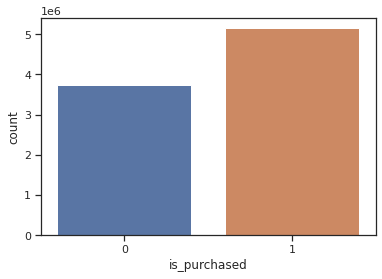

time: 891 ms (started: 2022-06-16 20:48:26 +00:00)


In [9]:
sns.countplot(x="is_purchased", data=df)

### Przygotowanie zbiorów testowych i treningowych.

In [10]:
features = df.iloc[:, :14]
target = df.iloc[:, 14]


X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.3, 
                                                    random_state=20)

print(Y_train.value_counts())
print(Y_test.value_counts())

1    3606029
0    2614305
Name: is_purchased, dtype: int64
1    1545238
0    1120620
Name: is_purchased, dtype: int64
time: 3.77 s (started: 2022-06-16 20:48:27 +00:00)


Zbiór danych należy zbalansować

In [11]:
rus = RandomUnderSampler()

X_train, Y_train = rus.fit_resample(X_train, Y_train)
Y_train.value_counts()

0    2614305
1    2614305
Name: is_purchased, dtype: int64

time: 3.55 s (started: 2022-06-16 20:48:30 +00:00)


## Trenowanie modeli, dobór parametrów, walidacja krzyżowa

Lista parametrów do walidacji krzyżowej

In [12]:
scores = ["accuracy", "precision", "recall", "f1"]

time: 970 µs (started: 2022-06-16 20:48:34 +00:00)


### Naive Bayes

Trenowanie modelu dla  domyślnych wartości parametrów.

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_gnb_pred = gnb.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_gnb_pred))
print("Precision:", metrics.precision_score(Y_test, Y_gnb_pred))
print("Recall:", metrics.recall_score(Y_test, Y_gnb_pred))
print(f"F1 Score: {f1_score(Y_test, Y_gnb_pred, average='macro')}")

Accuracy: 0.5510128446451387
Precision: 0.6467951387191344
Recall: 0.4965759319923533
F1 Score: 0.5507396927954853
time: 5.97 s (started: 2022-06-14 10:15:23 +00:00)


Walidacja krzyżowa

In [ ]:
gnb = GaussianNB()
gnb_scores = cross_validate(gnb, features, target, scoring=scores)

print(gnb_scores)
for k, v in gnb_scores.items():
    print(k, v.mean())

{'fit_time': array([2.51588845, 2.46081662, 2.47482204, 2.45298243, 2.47494626]), 'score_time': array([2.97746801, 2.92764163, 2.85877633, 2.88739467, 2.8457942 ]), 'test_accuracy': array([0.53069171, 0.58391584, 0.57494719, 0.57856798, 0.5717968 ]), 'test_precision': array([0.61168108, 0.60846266, 0.5953035 , 0.62064836, 0.58938201]), 'test_recall': array([0.52146849, 0.79165041, 0.83315263, 0.70221586, 0.86159419]), 'test_f1': array([0.56298377, 0.68807259, 0.6944262 , 0.65891739, 0.69995375])}
fit_time 2.4758911609649656
score_time 2.8994149684906008
test_accuracy 0.5679839037194179
test_precision 0.6050955242184768
test_recall 0.7420163177163472
test_f1 0.6608707419809743
time: 28.4 s (started: 2022-06-14 10:15:29 +00:00)


### Logistic regression

Trenowanie modelu dla domyślnych wartości parametrów.

In [ ]:
log_reg = LogisticRegression()

log_reg.fit(X_train, Y_train)
Y_log_reg_pred = log_reg.predict(X_test)
print("Accuracy:", metrics.accuracy_score(Y_test, Y_log_reg_pred))
print("Precision:", metrics.precision_score(Y_test, Y_log_reg_pred))
print("Recall:", metrics.recall_score(Y_test, Y_log_reg_pred))
print(f"F1 Score: {f1_score(Y_test, Y_log_reg_pred, average='macro')}")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.5507982795782821
Precision: 0.6196181630546955
Recall: 0.5828325474781231
F1 Score: 0.543683398425568
time: 1min 9s (started: 2022-06-14 10:15:57 +00:00)


Walidacja krzyżowa

In [ ]:
log_scores = cross_validate(log_reg, features, target, scoring=scores)

print(log_scores)
for k, v in log_scores.items():
    print(k, v.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'fit_time': array([82.02784491, 81.4820087 , 83.72186708, 84.66050816, 83.00975037]), 'score_time': array([2.59143543, 2.53475904, 2.4553237 , 2.48978281, 2.43625927]), 'test_accuracy': array([0.57053159, 0.59555862, 0.59935529, 0.60117666, 0.58995419]), 'test_precision': array([0.58923281, 0.59061828, 0.59267634, 0.59300567, 0.58612599]), 'test_recall': array([0.85561133, 0.98520365, 0.98762343, 0.99468965, 0.9958088 ]), 'test_f1': array([0.69786665, 0.73850893, 0.74079748, 0.74303501, 0.73791843])}
fit_time 82.98039584159851
score_time 2.501512050628662
test_accuracy 0.591315269413527
test_precision 0.5903318188691526
test_recall 0.9637873724580306
test_f1 0.7316252994905068
time: 7min 8s (started: 2022-06-14 10:17:06 +00:00)


Trenowanie modelu dla parametrów wybranych dla danych bez segmentów.

In [ ]:
log_reg = LogisticRegression(max_iter=500, C=0.1)

log_reg.fit(X_train, Y_train)
Y_pred_log_reg = log_reg.predict(X_test)
print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_log_reg))
print("Precision:", metrics.precision_score(Y_test, Y_pred_log_reg))
print("Recall:", metrics.recall_score(Y_test, Y_pred_log_reg))
print(f"F1 Score: {f1_score(Y_test, Y_pred_log_reg, average='macro')}")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.5565847843358498
Precision: 0.6225273931837905
Recall: 0.5970258303251668
fbeta: 0.5592078593499304
F1 Score: 0.5482868906780143
time: 5min 10s (started: 2022-06-14 10:24:15 +00:00)


Walidajca krzyżowa

In [ ]:
log_scores = cross_validate(log_reg, features, target, scoring=scores)

print(log_scores)
for k, v in log_scores.items():
    print(k, v.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'fit_time': array([263.95614672, 414.91166472, 403.75229692, 409.47166538,
       407.46393108]), 'score_time': array([2.67448568, 2.57898951, 2.52582979, 2.55780411, 2.50680184]), 'test_accuracy': array([0.56029943, 0.58813362, 0.60205836, 0.60268855, 0.59024453]), 'test_precision': array([0.58689753, 0.58838705, 0.59581849, 0.59552607, 0.58629744]), 'test_recall': array([0.81551637, 0.96362547, 0.97479842, 0.98069115, 0.99582239]), 'test_f1': array([0.68257244, 0.73064456, 0.73958572, 0.74104906, 0.73805803])}
fit_time 379.9111409664154
score_time 2.568782186508179
test_accuracy 0.5886848977533626
test_precision 0.5905853156384786
test_recall 0.9460907603973311
test_f1 0.7263819621565515
time: 31min 53s (started: 2022-06-14 10:29:26 +00:00)


### Decision tree

Trenowanie modelu dla domyślnych wartości parametrów.

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
Y_dtc_pred = dtc.predict(X_test)

print(f"Depth: {dtc.get_depth()}, Leaves{dtc.get_n_leaves()}")
print("Accuracy:", metrics.accuracy_score(Y_test, Y_dtc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_dtc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_dtc_pred))
print(f"F1 Score: {f1_score(Y_test, Y_dtc_pred, average='macro')}")

Depth: 67, Leaves1179450
Accuracy: 0.6673198647489851
Precision: 0.7395820596575194
Recall: 0.657612613720346
F1 Score: 0.6642876801212927
time: 2min 13s (started: 2022-06-14 09:03:46 +00:00)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 16), dpi=600)
tree.plot_tree(dtc, max_depth=10, feature_names=features.columns, class_names=True)
plt.savefig('dtc_with_seg.png')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Walidacja krzyżowa.

In [ ]:
dtc_scores = cross_validate(dtc, features, target, scoring=scores)

print(dtc_scores)
for k, v in dtc_scores.items():
    print(k, v.mean())

{'fit_time': array([110.64524746, 105.73131728, 104.27701187,  98.52037144,
       105.20484638]), 'score_time': array([2.3685894 , 2.51235557, 2.55733466, 2.64774632, 2.4772892 ]), 'test_accuracy': array([0.42106098, 0.54197944, 0.53486196, 0.46702186, 0.60754046]), 'test_precision': array([0.87437186, 0.58273849, 0.62057823, 0.55603475, 0.59677891]), 'test_recall': array([0.00152001, 0.73914879, 0.50852752, 0.39982897, 0.99583792]), 'test_f1': array([0.00303475, 0.65169013, 0.558993  , 0.46516841, 0.74631268])}
fit_time 104.87575888633728
score_time 2.5126630306243896
test_accuracy 0.5144929420774906
test_precision 0.6461004477945387
test_recall 0.5289726425123138
test_f1 0.485039795878725
time: 8min 58s (started: 2022-06-14 09:06:00 +00:00)


Trenowanie modelu dla parametrów wybranych dla danych bez segmentów.

In [13]:
dtc = DecisionTreeClassifier(max_leaf_nodes=16, max_depth=7)
dtc.fit(X_train, Y_train)
Y_dtc_pred = dtc.predict(X_test)

print(f"Depth: {dtc.get_depth()}, Leaves {dtc.get_n_leaves()}")
print("Accuracy:", metrics.accuracy_score(Y_test, Y_dtc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_dtc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_dtc_pred))
print(f"F1 Score: {f1_score(Y_test, Y_dtc_pred, average='macro')}")

Depth: 7, Leaves 16
Accuracy: 0.6839006428699503
Precision: 0.6943353680732817
Recall: 0.8122256895054354
F1 Score: 0.6614161592397967
time: 57.8 s (started: 2022-06-16 20:48:34 +00:00)


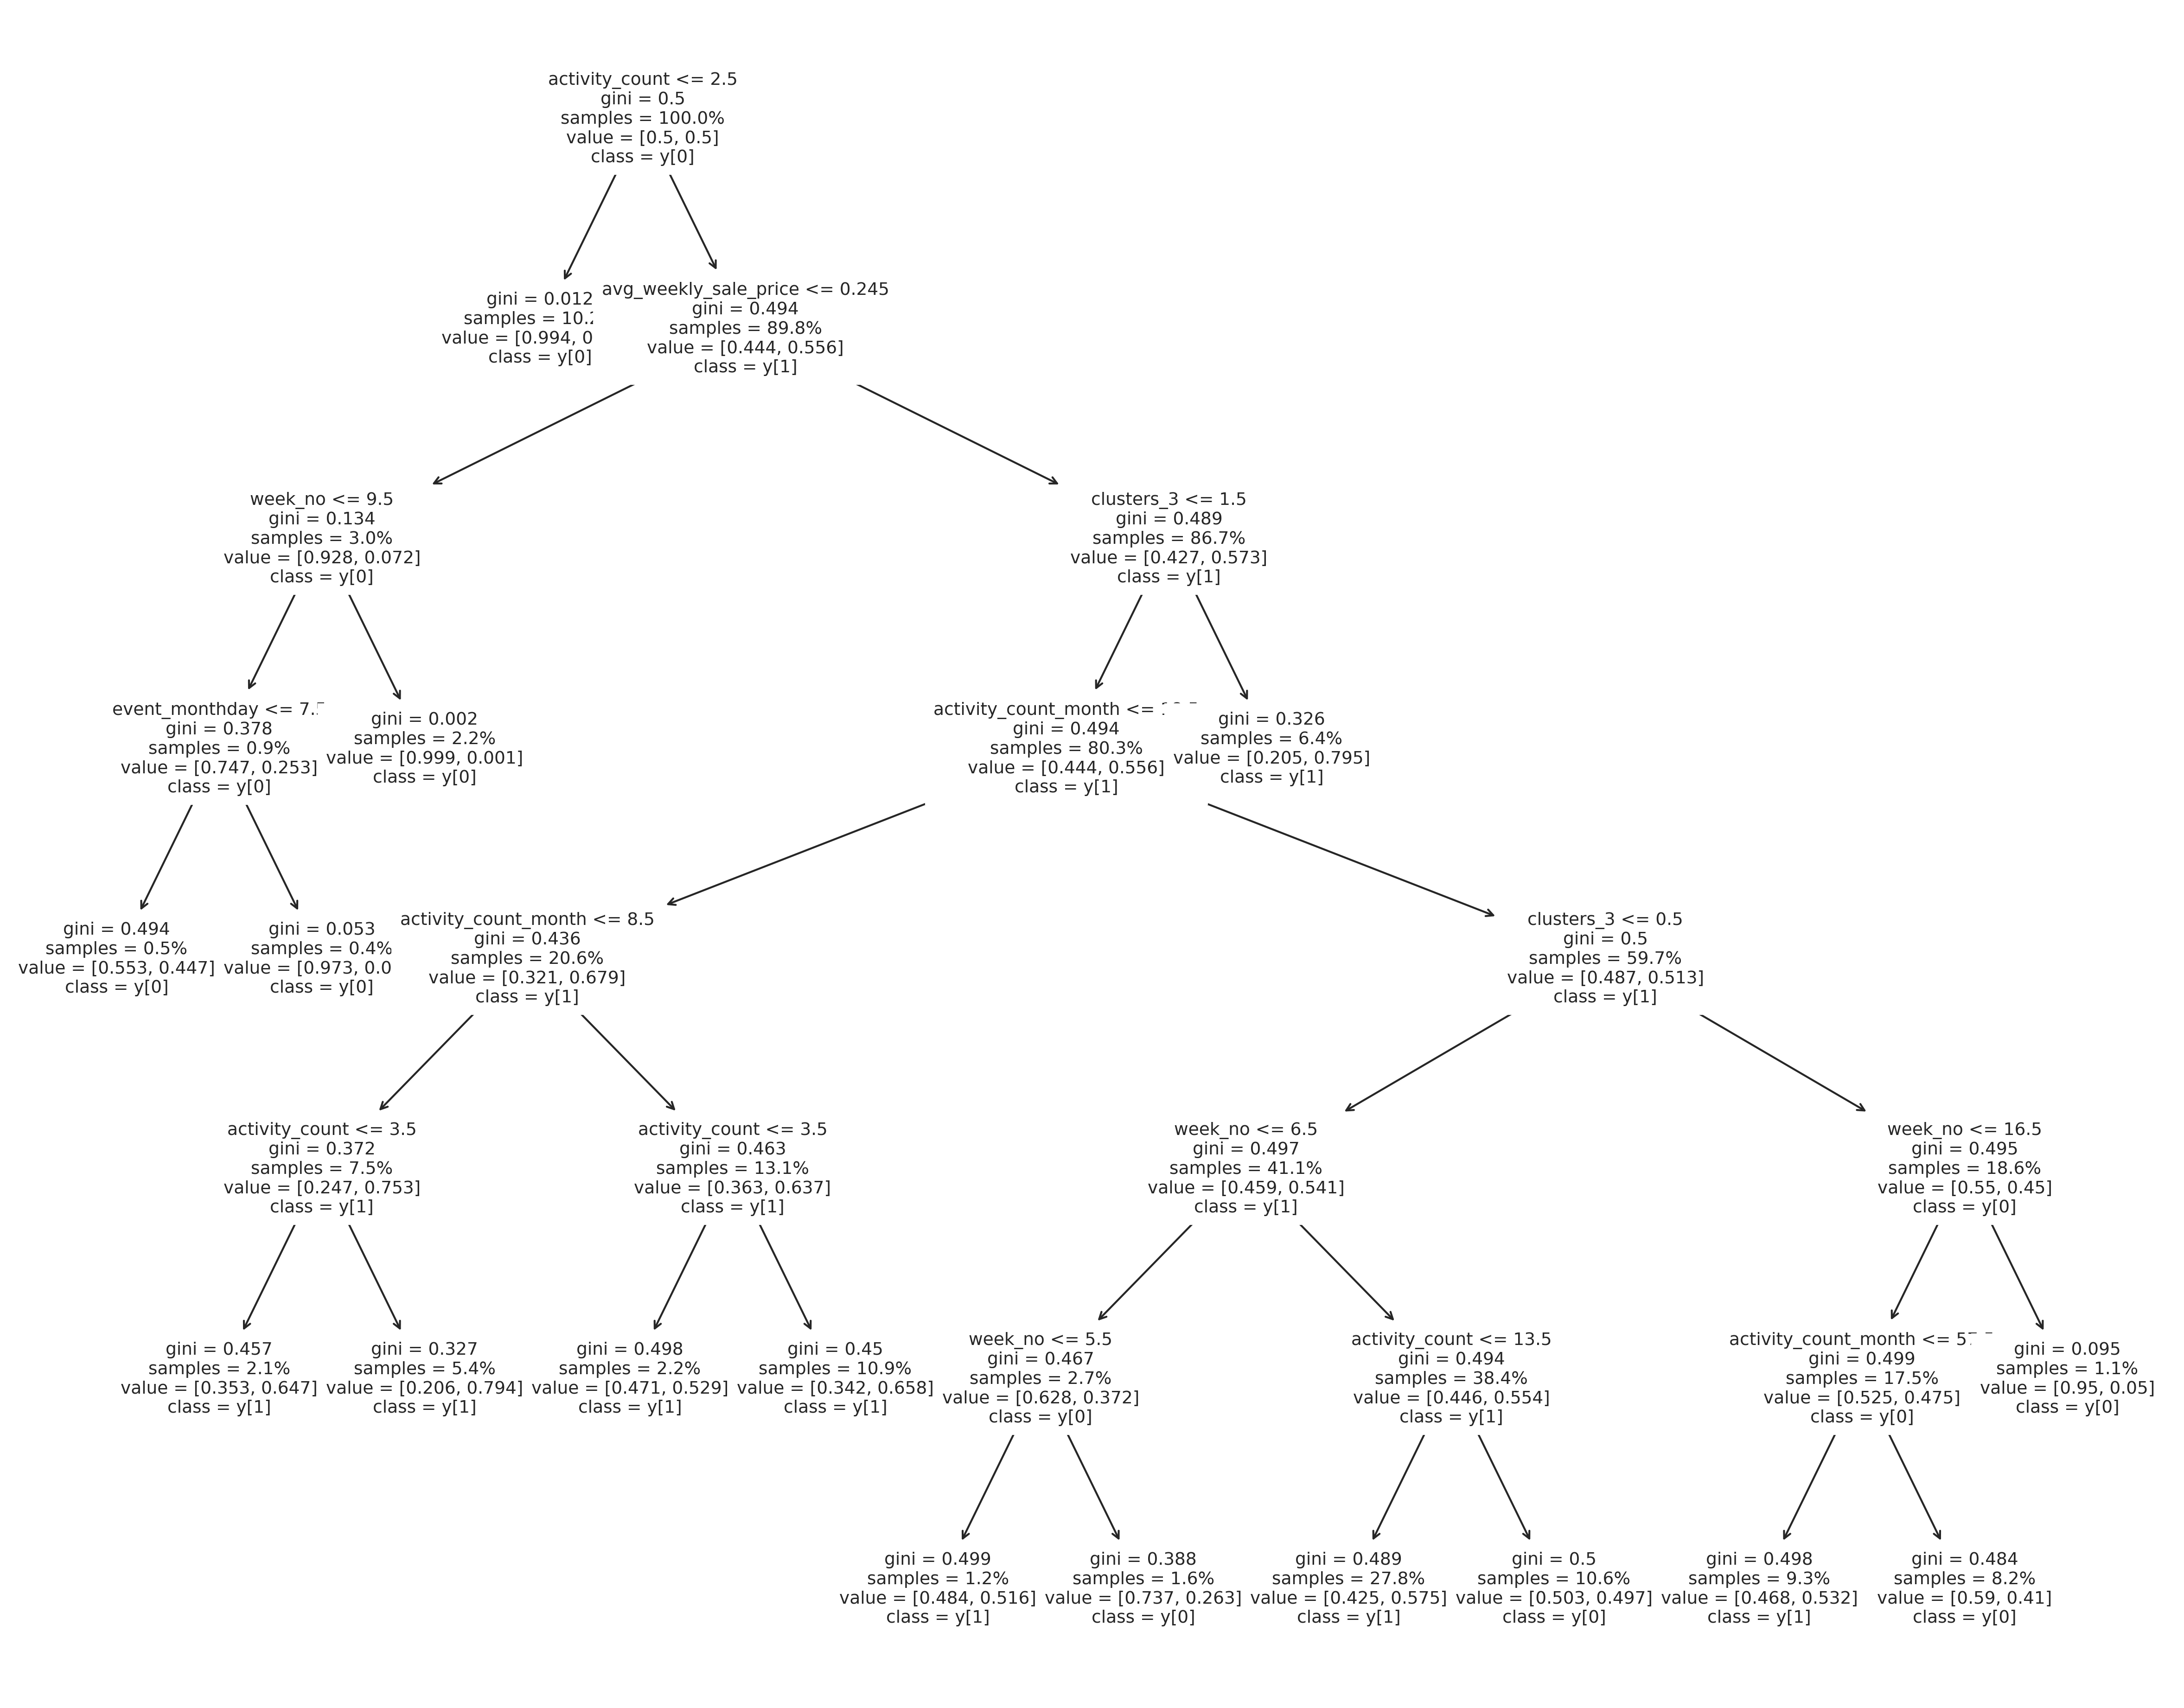

time: 7.06 s (started: 2022-06-16 20:55:01 +00:00)


In [17]:
fig, ax = plt.subplots(figsize=(20, 16), dpi=300)
tree.plot_tree(dtc, feature_names=features.columns, class_names=True, proportion=True, fontsize=9)
plt.savefig('dtc_with_seg_param.png')
plt.show()

Walidajca krzyżowa

In [14]:
dtc_scores = cross_validate(dtc, features, target, scoring=scores)

print(dtc_scores)
for k, v in dtc_scores.items():
    print(k, v.mean())

{'fit_time': array([50.24589992, 47.31110811, 49.17856741, 47.13611031, 49.69210219]), 'score_time': array([2.46749163, 2.65488172, 2.65156507, 2.72491121, 2.65191221]), 'test_accuracy': array([0.42208336, 0.64048392, 0.6746007 , 0.72188137, 0.6582146 ]), 'test_precision': array([1.        , 0.61729786, 0.69477411, 0.67602937, 0.62920548]), 'test_recall': array([0.00306526, 0.99942247, 0.78238452, 0.99895754, 0.99929144]), 'test_f1': array([0.00611179, 0.76320108, 0.73598123, 0.80636408, 0.7721963 ])}
fit_time 48.71275758743286
score_time 2.630152368545532
test_accuracy 0.6234527888141853
test_precision 0.7234613650186583
test_recall 0.7566242461826879
test_f1 0.6167708959489673
time: 4min 18s (started: 2022-06-16 20:49:33 +00:00)


### Random forest

Trenowanie modelu dla domyślnych wartości parametrów.

In [ ]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, Y_train)
Y_rfc_pred = rfc.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_rfc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_rfc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_rfc_pred))
print(f"F1 Score: {f1_score(Y_test, Y_rfc_pred, average='macro')}")

Accuracy: 0.6890370754931433
Precision: 0.7598751882154454
Recall: 0.6776723067902809
F1 Score: 0.6861095088112352
time: 4min 4s (started: 2022-06-14 09:18:50 +00:00)


Walidacja krzyżowa

In [ ]:
rfc = RandomForestClassifier(n_estimators=10)
rfc_scores = cross_validate(rfc, features, target, scoring=scores)

print(rfc_scores)
for k, v in rfc_scores.items():
    print(k, v.mean())

{'fit_time': array([192.33822751, 181.54172754, 180.4696312 , 179.60124063,
       183.74181771]), 'score_time': array([3.87338018, 4.79674745, 4.58410764, 5.01305795, 3.91067314]), 'test_accuracy': array([0.42109306, 0.55738986, 0.52053974, 0.47243363, 0.62049484]), 'test_precision': array([0.99786325, 0.59510259, 0.62199729, 0.56058565, 0.60445338]), 'test_recall': array([0.00135986, 0.73987094, 0.44077911, 0.41601238, 0.99919534]), 'test_f1': array([0.00271602, 0.65963722, 0.51593809, 0.47759787, 0.75324102])}
fit_time 183.53852891921997
score_time 4.4355932712554935
test_accuracy 0.5183902236523285
test_precision 0.6760004300361265
test_recall 0.5194435267393925
test_f1 0.4818260426844857
time: 15min 41s (started: 2022-06-14 09:22:54 +00:00)


Trenowanie modelu dla parametrów wybranych dla danych bez segmentów.

In [ ]:
rfc = RandomForestClassifier(n_estimators=20,
                             max_leaf_nodes=16,
                             max_depth=7)
rfc.fit(X_train, Y_train)
Y_rfc_pred = rfc.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_rfc_pred))
print("Precision:", metrics.precision_score(Y_test, Y_rfc_pred))
print("Recall:", metrics.recall_score(Y_test, Y_rfc_pred))
print(f"F1 Score: {f1_score(Y_test, Y_rfc_pred, average='macro')}")

Accuracy: 0.6971710421185224
Precision: 0.69155753301266
Recall: 0.8620335508187088
F1 Score: 0.6667429940852945
time: 3min 37s (started: 2022-06-14 09:38:36 +00:00)


Walidajca krzyżowa

In [ ]:
rfc_scores = cross_validate(rfc, features, target, scoring=scores)

print(rfc_scores)
for k, v in rfc_scores.items():
    print(k, v.mean())

{'fit_time': array([126.10245538, 120.32327151, 118.99448347, 120.00460744,
       124.03978133]), 'score_time': array([4.04059029, 4.23500252, 4.1413579 , 4.39534712, 4.07825255]), 'test_accuracy': array([0.42422319, 0.66252429, 0.58753133, 0.7045618 , 0.65822023]), 'test_precision': array([0.89456978, 0.63215101, 0.65181288, 0.66263169, 0.62920175]), 'test_recall': array([0.00765928, 0.99937394, 0.61927895, 0.99895754, 0.99933803]), 'test_f1': array([0.01518851, 0.77443528, 0.63512956, 0.7967564 , 0.7722074 ])}
fit_time 121.89291982650757
score_time 4.178110074996948
test_accuracy 0.6074121657597376
test_precision 0.6940734202881323
test_recall 0.724921547031027
test_f1 0.5987434296964107
time: 10min 31s (started: 2022-06-14 09:42:13 +00:00)


### XGBoost

Trenowanie modelu dla domyślnych wartości parametrów.

In [ ]:
xgb = XGBClassifier(tree_method="gpu_hist")
xgb.fit(X_train, Y_train)
Y_pred_xgb = xgb.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_xgb))
print("Precision:", metrics.precision_score(Y_test, Y_pred_xgb))
print("Recall:", metrics.recall_score(Y_test, Y_pred_xgb))
print(f"F1 Score: {f1_score(Y_test, Y_pred_xgb, average='macro')}")

Accuracy: 0.7137897067285655
Precision: 0.7161694465231805
Recall: 0.8385659684786422
F1 Score: 0.6933216391851544
time: 8.15 s (started: 2022-06-14 09:52:45 +00:00)


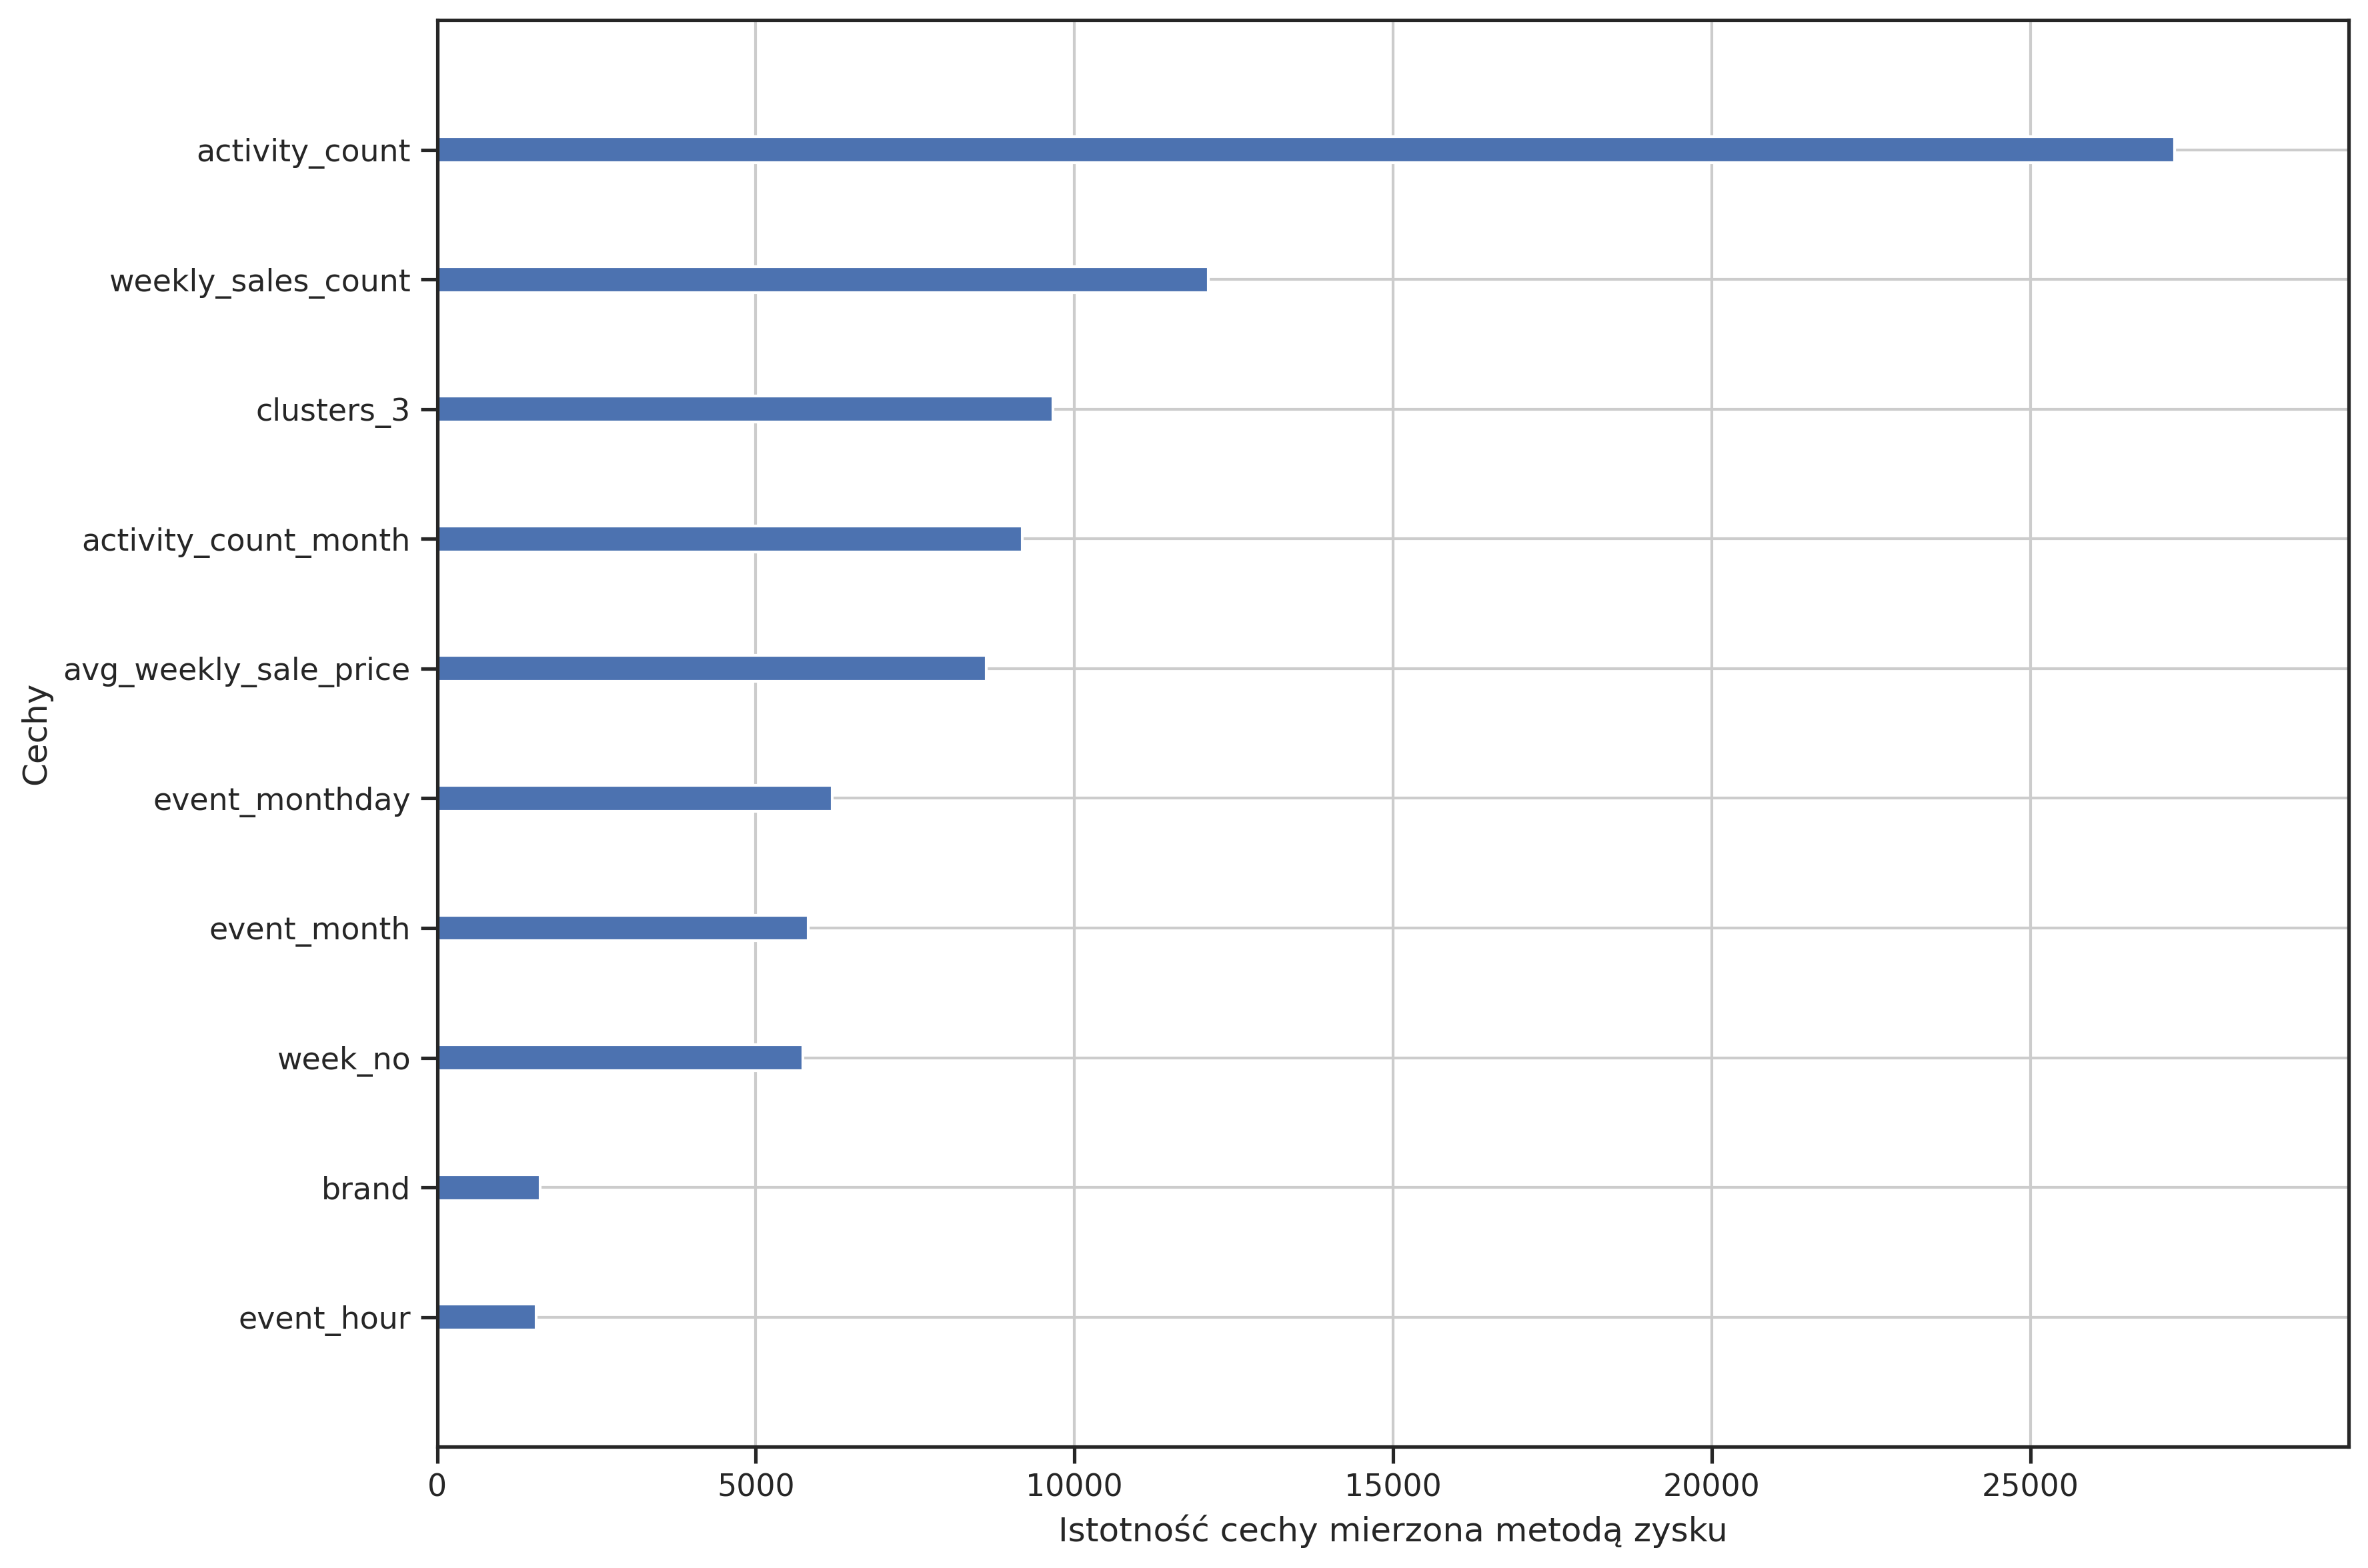

time: 2.23 s (started: 2022-06-14 09:52:53 +00:00)


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
plot_importance(xgb, max_num_features=10,
                importance_type='gain',
                ax=ax,
                title="",
                show_values=False,
                xlabel="Istotność cechy mierzona metodą zysku",
                ylabel="Cechy")

plt.tight_layout()
plt.savefig('xgb_with_seg.png')
plt.show()

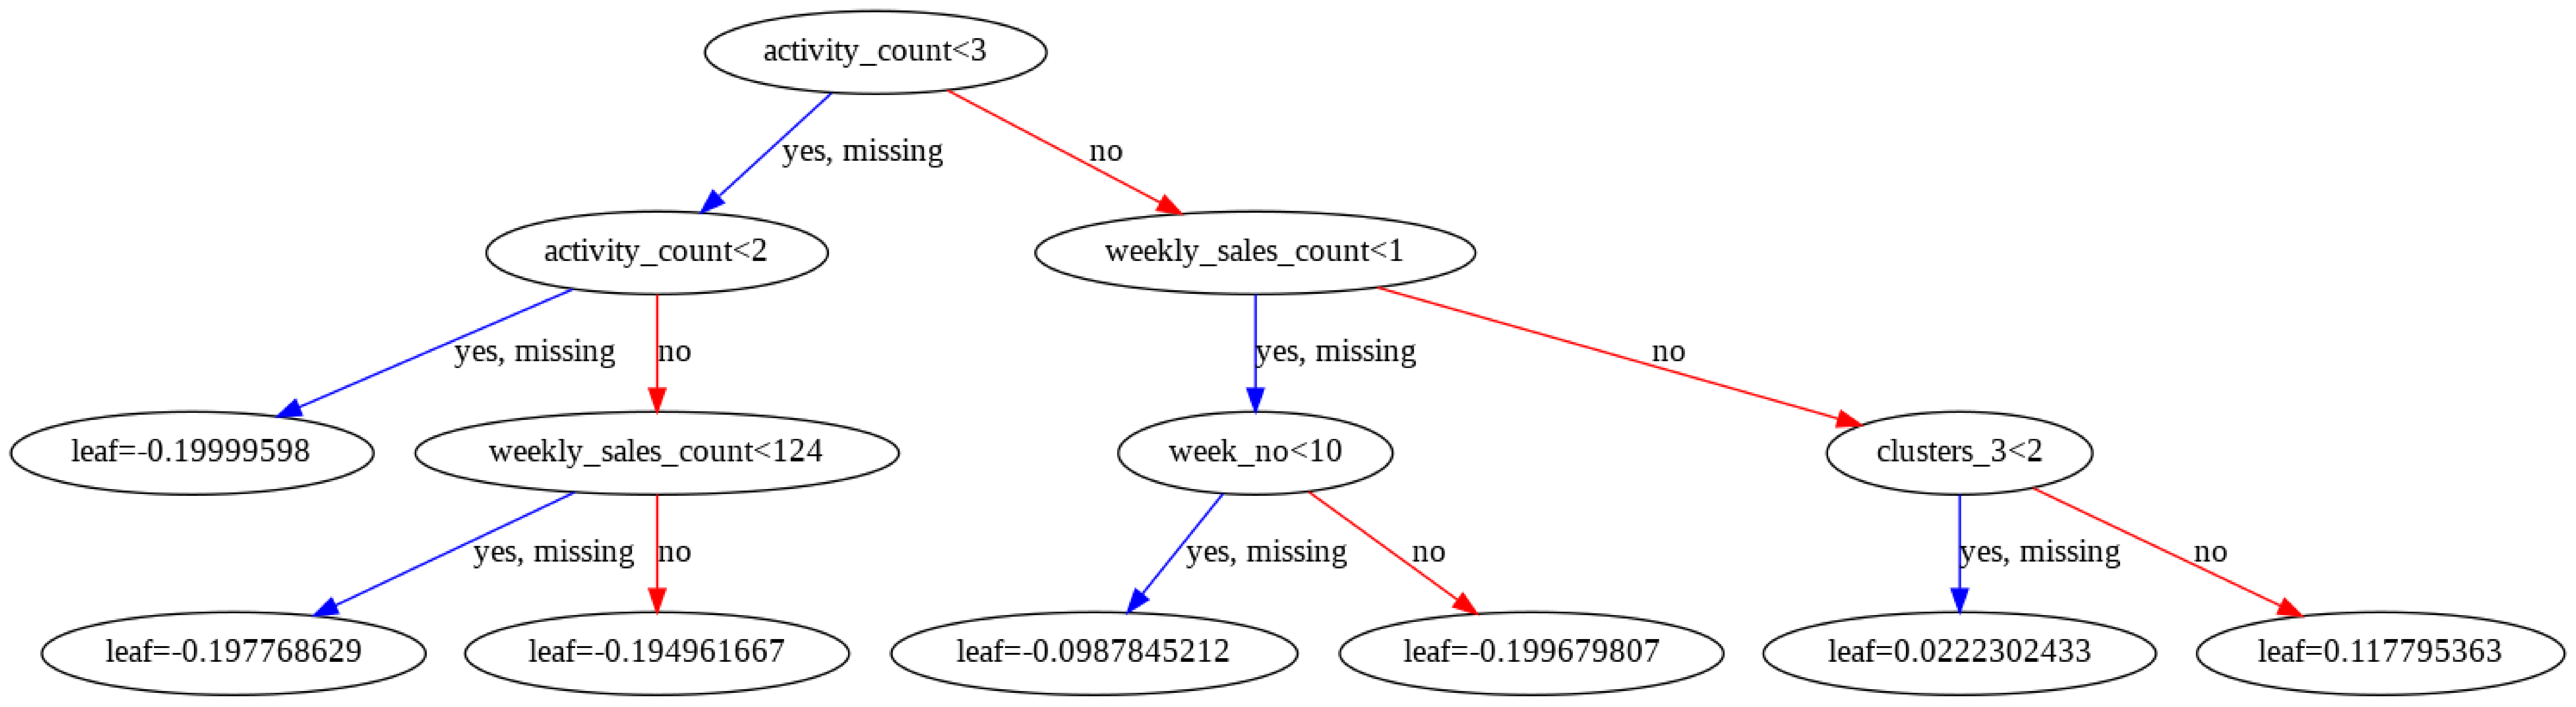

time: 14.2 s (started: 2022-06-14 09:52:55 +00:00)


In [ ]:
plot_tree(xgb, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('xgb_tree_with_seg.png')

Walidacja krzyżowa

In [ ]:
xgb_scores = cross_validate(xgb, features, target, scoring=scores)

print(xgb_scores)
for k, v in xgb_scores.items():
    print(k, v.mean())

{'fit_time': array([4.59700871, 4.52285385, 4.57525682, 4.53737783, 4.58988476]), 'score_time': array([2.61998081, 2.8480649 , 2.73174834, 2.87948298, 2.77638125]), 'test_accuracy': array([0.42204453, 0.61828713, 0.56810287, 0.58224391, 0.63294787]), 'test_precision': array([1.        , 0.6207278 , 0.63856905, 0.61904695, 0.61402762]), 'test_recall': array([0.00299829, 0.87798737, 0.58745764, 0.72631286, 0.98763605]), 'test_f1': array([0.00597865, 0.72727784, 0.61194796, 0.66840373, 0.75725738])}
fit_time 4.564476394653321
score_time 2.771131658554077
test_accuracy 0.5647252601698073
test_precision 0.6984742849702748
test_recall 0.6364784415118112
test_f1 0.5541731144691215
time: 38.3 s (started: 2022-06-14 09:53:10 +00:00)


Trenowanie modelu dla parametrów wybranych dla danych bez segmentów.

In [ ]:
xgb = XGBClassifier(learning_rate=1,
                    max_depth=4,
                    n_estimators=250,
                    tree_method="gpu_hist")

xgb.fit(X_train, Y_train)
Y_pred_xgb = xgb.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_xgb))
print("Precision:", metrics.precision_score(Y_test, Y_pred_xgb))
print("Recall:", metrics.recall_score(Y_test, Y_pred_xgb))
print(f"F1 Score: {f1_score(Y_test, Y_pred_xgb, average='macro')}")

Accuracy: 0.7317295219775397
Precision: 0.732842701363226
Recall: 0.8453487423943755
F1 Score: 0.7141082368789606
time: 10.8 s (started: 2022-06-14 09:53:48 +00:00)


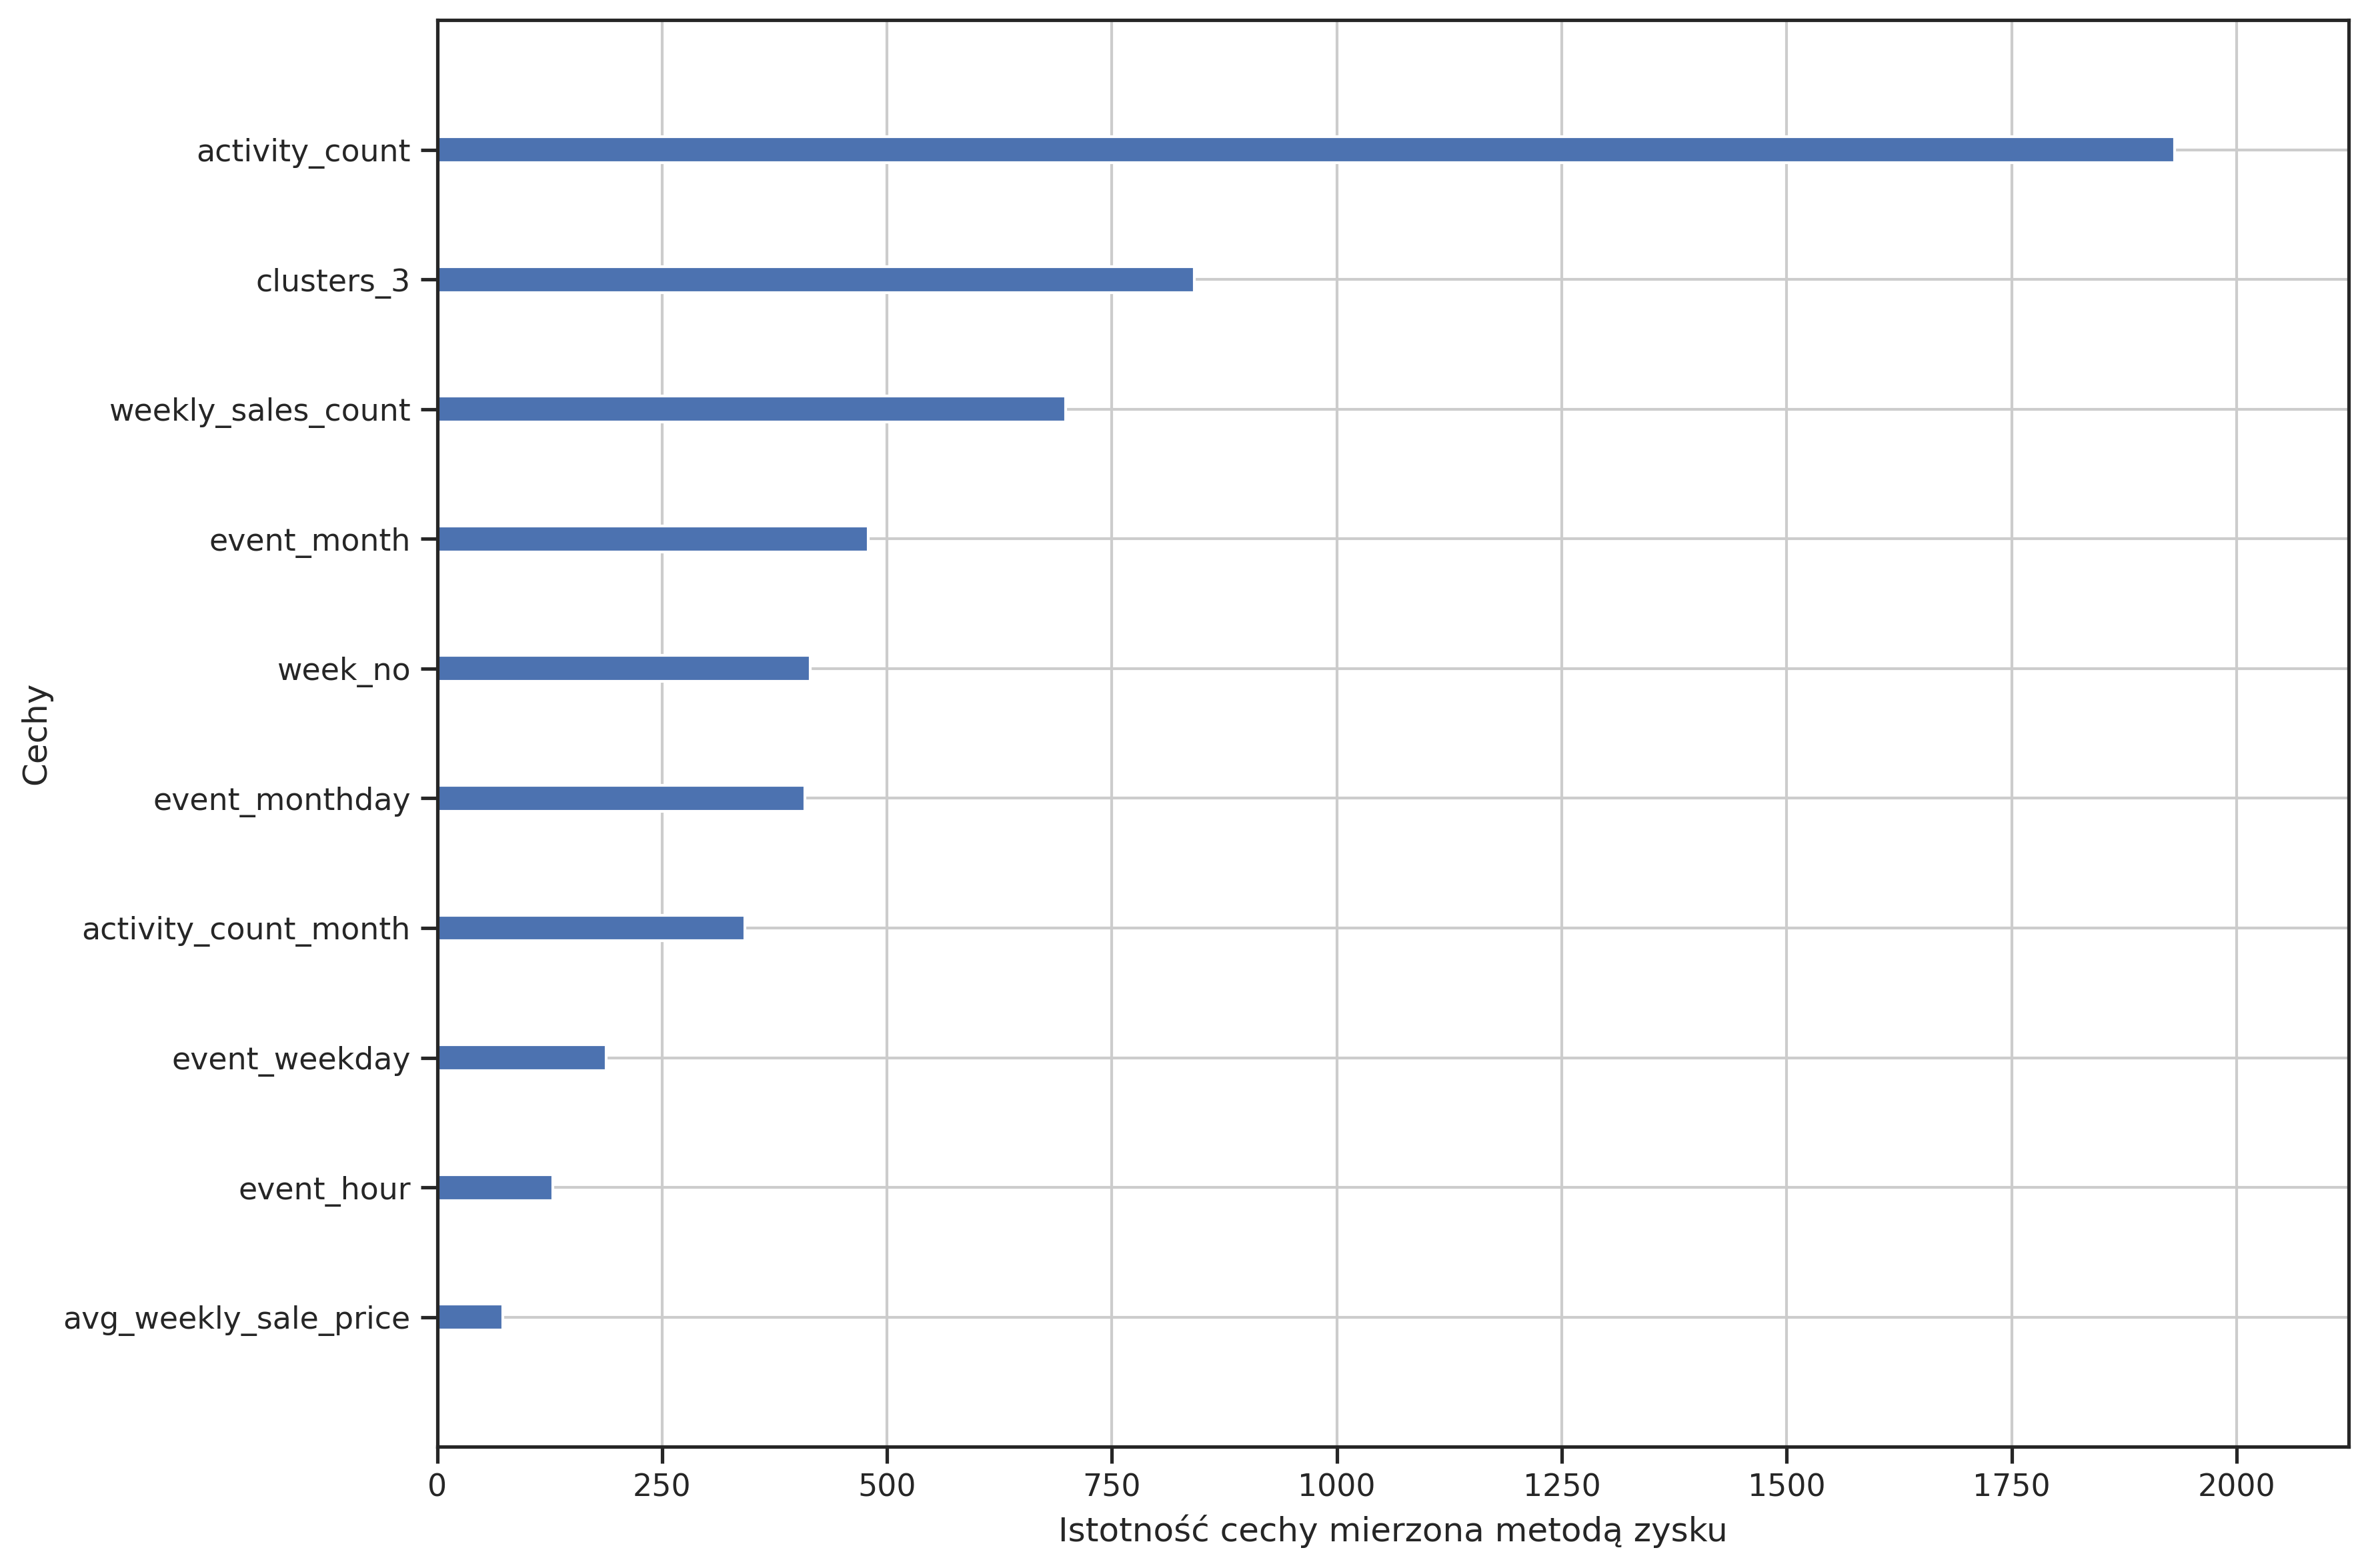

time: 2.29 s (started: 2022-06-14 09:53:59 +00:00)


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
plot_importance(xgb, max_num_features=10,
                importance_type='gain',
                ax=ax,
                title="",
                show_values=False,
                xlabel="Istotność cechy mierzona metodą zysku",
                ylabel="Cechy")

plt.tight_layout()
plt.savefig('xgb_with_seg_param.png')
plt.show()

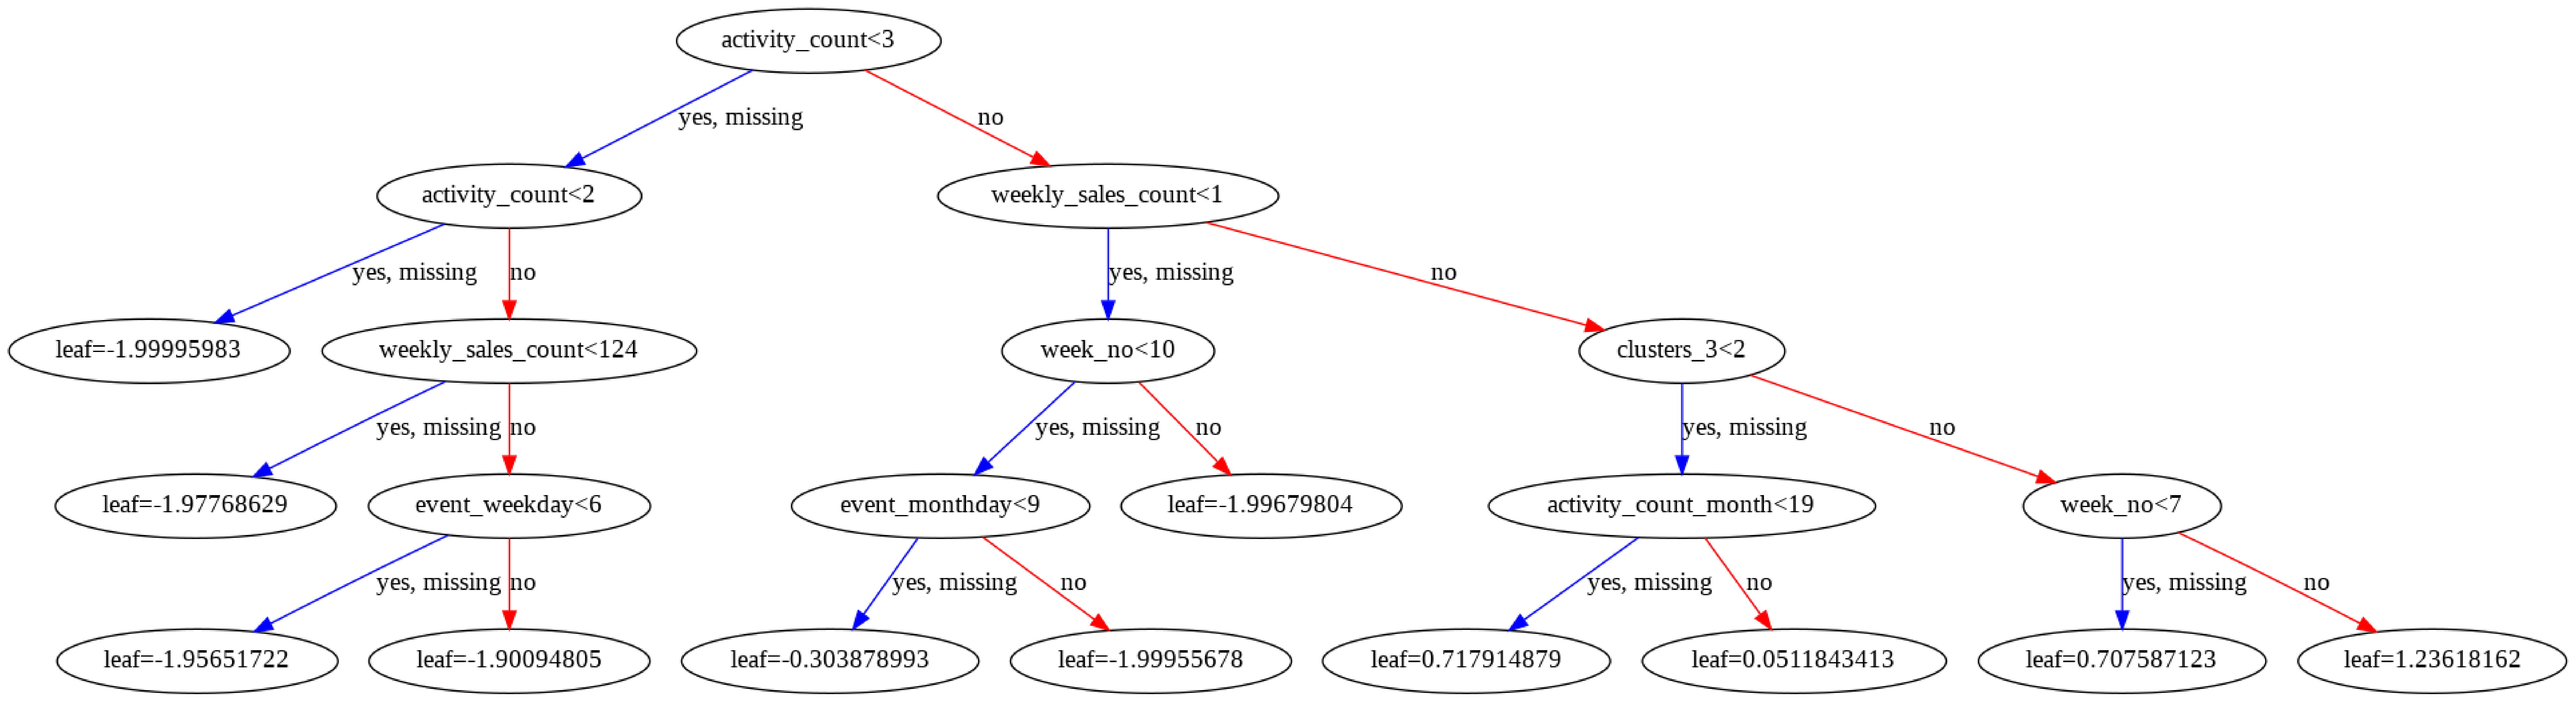

time: 14 s (started: 2022-06-14 09:54:01 +00:00)


In [ ]:
plot_tree(xgb, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('xgb_tree_with_seg_param.png')

Walidajca krzyżowa

In [ ]:
xgb_scores = cross_validate(xgb, features, target, scoring=scores)

print(xgb_scores)
for k, v in xgb_scores.items():
    print(k, v.mean())

{'fit_time': array([8.72937822, 8.71112967, 8.71204805, 8.77078819, 8.79620767]), 'score_time': array([2.68877935, 2.70130873, 2.76736045, 2.83470511, 2.85745859]), 'test_accuracy': array([0.42072507, 0.52876119, 0.4257719 , 0.49447457, 0.62390237]), 'test_precision': array([1.        , 0.57234415, 0.50372999, 0.56134308, 0.61141526]), 'test_recall': array([7.22152013e-04, 7.40071866e-01, 6.36604795e-01, 5.85396985e-01,
       9.63677854e-01]), 'test_f1': array([0.00144326, 0.64549015, 0.56242593, 0.57311775, 0.74815557])}
fit_time 8.743910360336304
score_time 2.76992244720459
test_accuracy 0.4987270191739932
test_precision 0.6497664957336939
test_recall 0.5852947303635092
test_f1 0.5061265338470434
time: 59.2 s (started: 2022-06-14 09:54:15 +00:00)


### LightGBM

Trenowanie modelu dla domyślnych wartości parametrów.

In [ ]:
lgbm = lgb.LGBMClassifier(device="gpu",
                          gpu_platform_id=0,
                          gpu_device_id=0)
lgbm.fit(X_train, Y_train)
Y_pred_lgbm = lgbm.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_lgbm))
print("Precision:", metrics.precision_score(Y_test, Y_pred_lgbm))
print("Recall:", metrics.recall_score(Y_test, Y_pred_lgbm))
print(f"F1 Score: {f1_score(Y_test, Y_pred_lgbm, average='macro')}")

[LightGBM] [Info] Number of positive: 2614305, number of negative: 2614305
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 5228610, number of used features: 14
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (79.78 MB) transferred to GPU in 0.101425 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.7318941969152145
Precision: 0.7280975728725969
Recall: 0.8578005459353187
F1 Score: 0.7120468519393176
time: 1min 18s (started: 2022-06-14 09:55:14 +00:00)


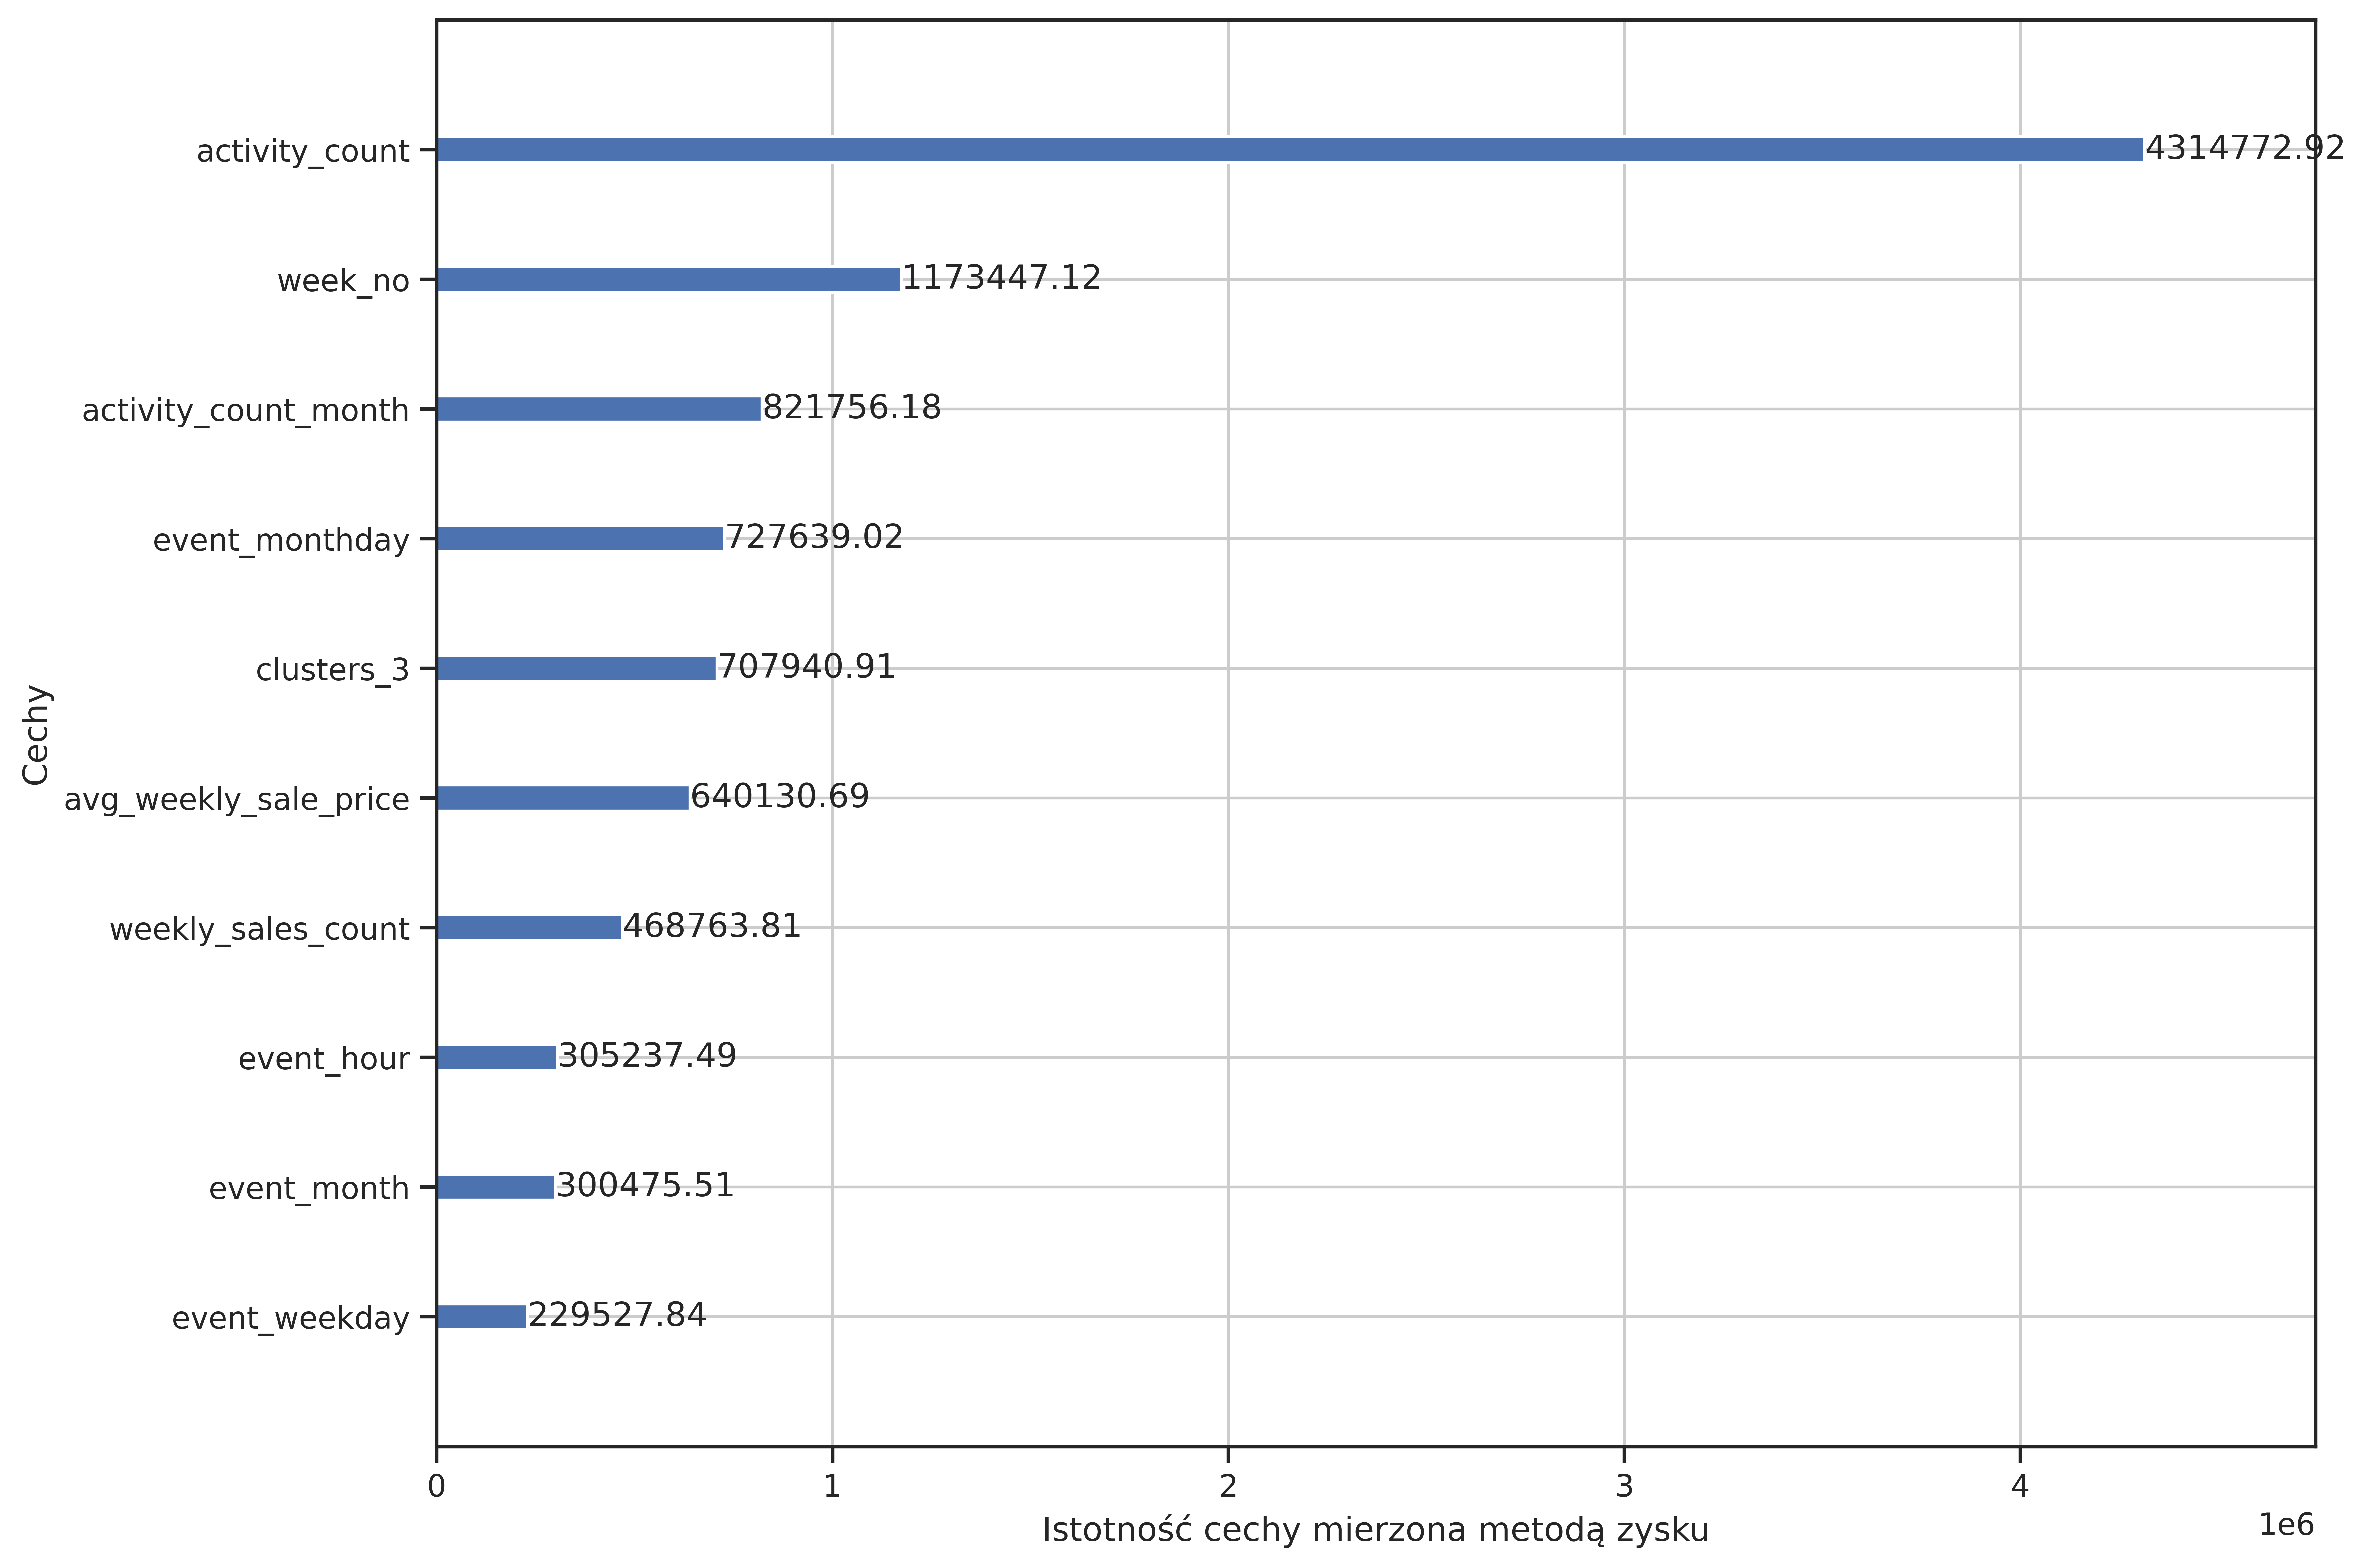

time: 8.24 s (started: 2022-06-14 09:56:33 +00:00)


In [ ]:
plot_importance_lgbm(lgbm,
                     max_num_features=10,
                     importance_type='gain',
                     title="",
                     xlabel="Istotność cechy mierzona metodą zysku",
                     ylabel="Cechy",
                     figsize=(12, 8),
                     precision=2,
                     dpi=600)
plt.tight_layout()
plt.savefig('lgbm_with_seg.png')
plt.show()

In [ ]:
plot_tree_lgbm(lgbm,
               tree_index=0,
               figsize=(20,16),
               dpi=600)
fig = plt.gcf()
fig.savefig('lgbm_tree_with_seg.png')

Output hidden; open in https://colab.research.google.com to view.

Walidacja krzyżowa

In [ ]:
lgbm_scores = cross_validate(lgbm, features, target, scoring=scores)

print(lgbm_scores)
for k, v in lgbm_scores.items():
    print(k, v.mean())

[LightGBM] [Info] Number of positive: 4121013, number of negative: 2987940
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 7108953, number of used features: 14
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 13 dense feature groups (108.47 MB) transferred to GPU in 0.137276 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579693 -> initscore=0.321515
[LightGBM] [Info] Start training from score 0.321515
[LightGBM] [Info] Number of positive: 4121013, number of negative: 2987940
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1606
[LightGBM] [Info] Number of data points in the trai

Trenowanie modelu dla parametrów wybranych dla danych bez segmentów.

In [ ]:
lgbm = lgb.LGBMClassifier(learning_rate=1,
                          n_estimators=200,
                          max_depth=4)
lgbm.fit(X_train, Y_train)
Y_pred_lgbm = lgbm.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred_lgbm))
print("Precision:", metrics.precision_score(Y_test, Y_pred_lgbm))
print("Recall:", metrics.recall_score(Y_test, Y_pred_lgbm))
print(f"F1 Score: {f1_score(Y_test, Y_pred_lgbm, average='macro')}")

[LightGBM] [Info] Number of positive: 2614305, number of negative: 2614305
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.208070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1609
[LightGBM] [Info] Number of data points in the train set: 5228610, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

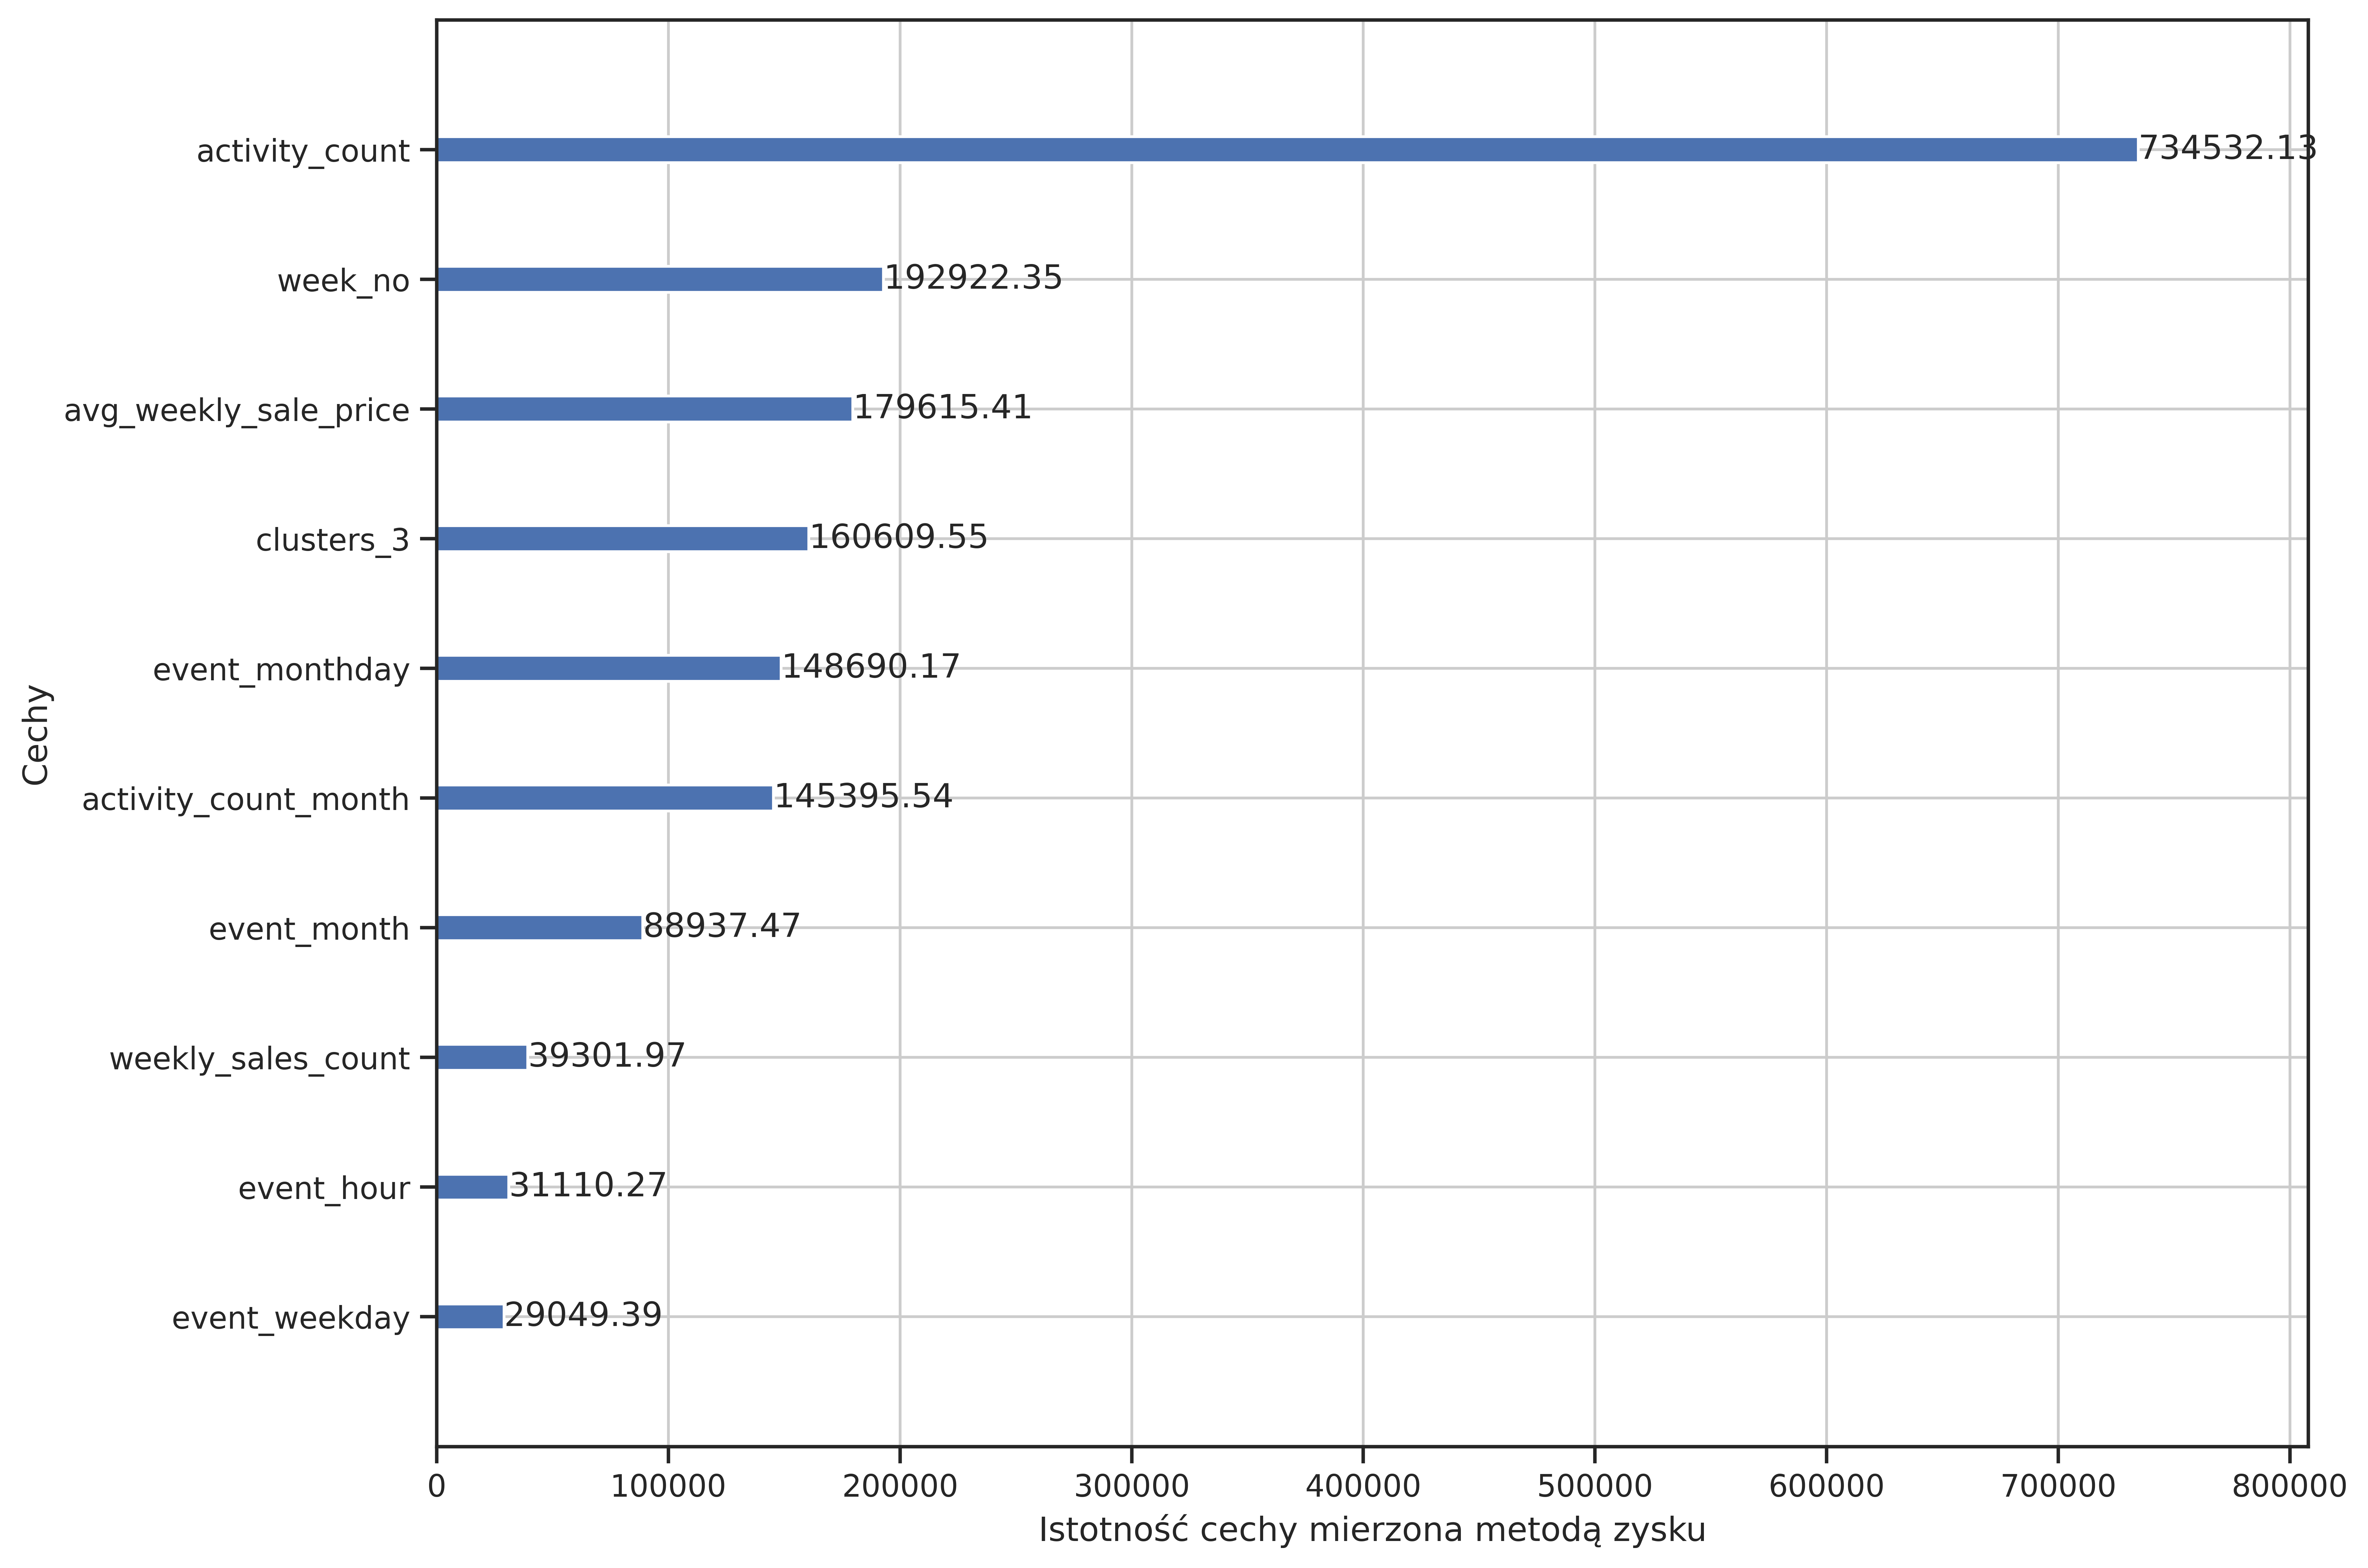

time: 8.28 s (started: 2022-06-14 10:04:24 +00:00)


In [ ]:
plot_importance_lgbm(lgbm,
                     max_num_features=10,
                     importance_type='gain',
                     title="",
                     xlabel="Istotność cechy mierzona metodą zysku",
                     ylabel="Cechy",
                     figsize=(12, 8),
                     precision=2,
                     dpi=600)
plt.tight_layout()
plt.savefig('lgbm_with_seg_param.png')
plt.show()

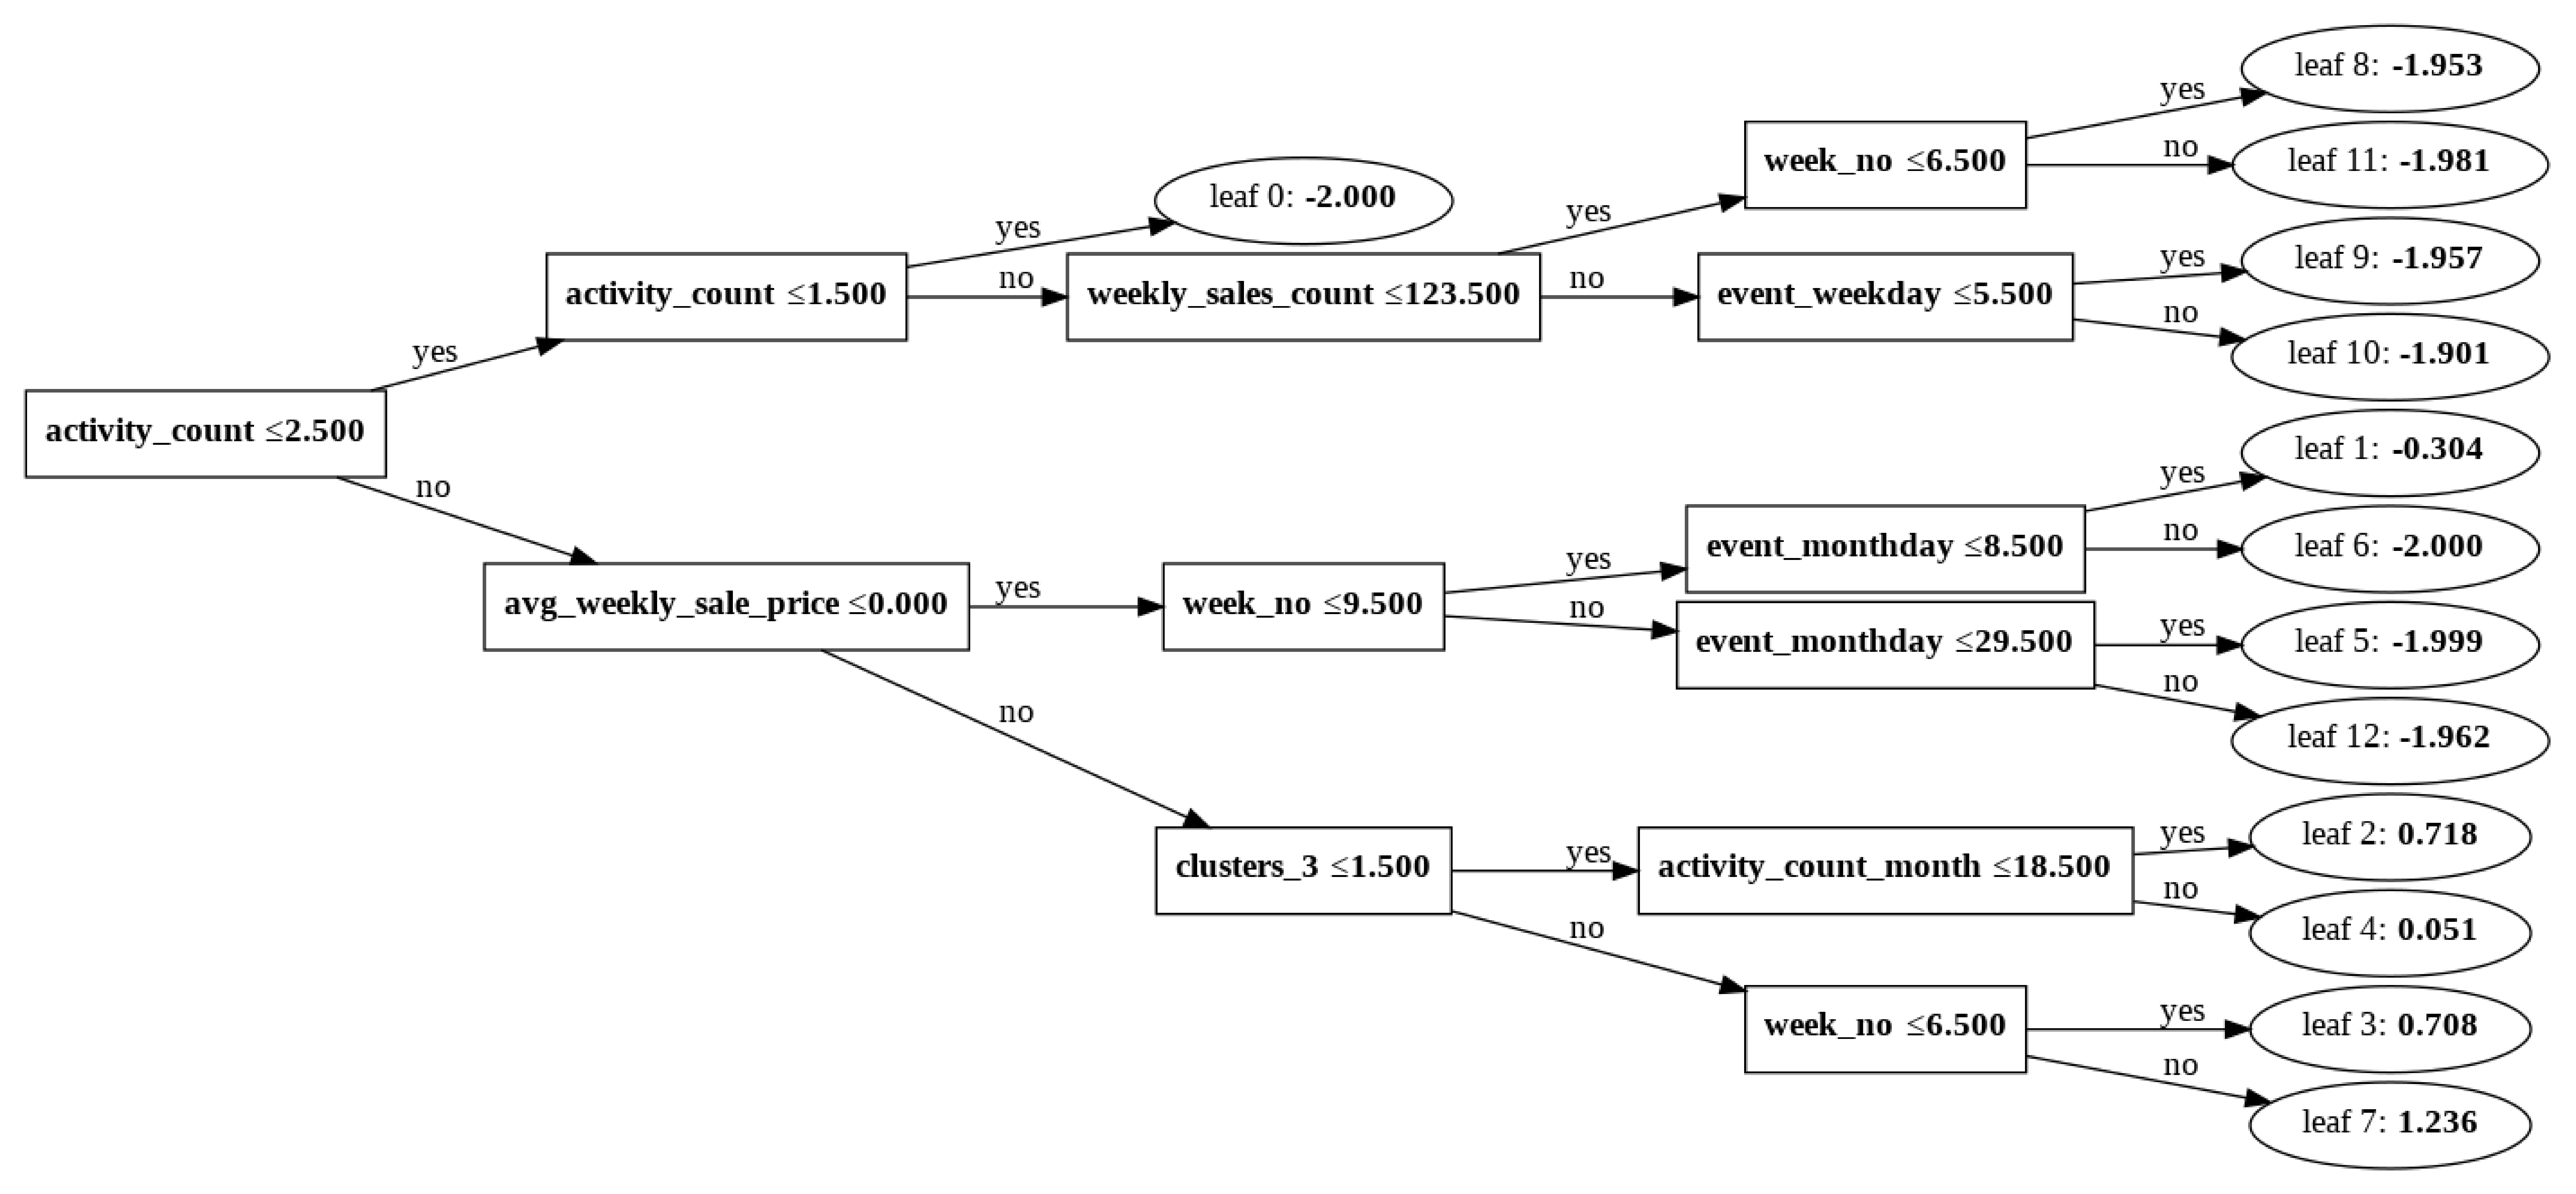

time: 23.6 s (started: 2022-06-14 10:04:32 +00:00)


In [ ]:
plot_tree_lgbm(lgbm,
               tree_index=0,
               figsize=(20,16),
               dpi=600)
fig = plt.gcf()
fig.savefig('lgbm_tree_with_seg_param.png')

Walidajca krzyżowa

In [ ]:
lgbm_scores = cross_validate(lgbm, features, target, scoring=scores)

print(lgbm_scores)
for k, v in lgbm_scores.items():
    print(k, v.mean())

[LightGBM] [Info] Number of positive: 4121013, number of negative: 2987940
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.335150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 7108953, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579693 -> initscore=0.321515
[LightGBM] [Info] Start training from score 0.321515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b